# CAPSTONE PROJECT - MODEL TUNING

**Objective**

   1. Explore and visualize the dataset.
   2.  Build a classification model to predict if the customer is going to churn or not
   3. Optimize the model using appropriate techniques
   4. Generate a set of insights and recommendations that will help the bank

**Data Description:**
* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then 1 else 0
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level: Educational Qualification of the account holder
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: Total Revolving Balance on the Credit Card
* Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
* Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
* Avg_Utilization_Ratio: Average Card Utilization Ratio

# IMPORT NECESSARY PACKAGES

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy
import seaborn as sns
sns.set(font_scale=1)
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score
import os
import json
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import random
import time # To time the execution time for GridSearchCV and RandomSearchCV
from sklearn.decomposition import PCA 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import sklearn
import imblearn

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Determine the number of CPUs and use all of them but 1
F multiprocessing
# Get CPU count
c_count = multiprocessing.cpu_count()
c_count = c_count - 1
if c_count <= 0: # If the computer has one GPU use that one.
    c_count = 1

In [ ]:
print(np.__version__)
print(sklearn.__version__)
print(imblearn.__version__)
print(pd.__version__)
print(sns.__version__)

# DATA STRUCTURE

In [ ]:
#Load the dataset
df_original = pd.read_csv("BankChurners.csv")
# makde a copy of the loaded dataframe into a variable df.
# we will modify df throughout the process
df = df_original.copy()
df.head(2)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

**Comments**
- There are 10127 rows and 21 columns. There are also both numeric and categorical columns. Numeric columns include Customer_Age, Dependent_count, Months_on_book among others. Categorical columns includes Attrition_flag, Gender, Card_Category, Income_Category etc. Among the categorical columns, there are some ordinal columns which includes Income_Category, Card_Category and Education_Level.
- CLIENTNUM -Client number. Unique identifier for the customer holding the account. This attribute is not significant in our study and we will drop it during model building.
- There are no missing values in our data from Python check but on a close look at the data the missing values appear has "Unknown". Despite this fact, we found the optimum action is to encode the "Unknown" values instead of replacing them. This is best on the columns located - no best imputation policy- and dropping the missing values leads to a drop in the perfomarmance of the moodel.

In [ ]:
def ProcessNulls(df, column):
    count = df.loc[df[column] == 'Unknown', [column]].shape[0] 
    percent = count / df.shape[0]
    return str(round(percent,2))+"%"

all_details = []

for column in df.columns:
    all_details.append({column:ProcessNulls(df, column)})
    
#Format the output using JSON

print(json.dumps(all_details, indent=3))

In [3]:
df.describe(include="all")

NameError: name 'df' is not defined

**Remarks:**
- On attrition, existing customer is a dominant class with 8500 customer. 
- Majority of the customers were female.
- On education, majority of the 10127 customers were graduations - a total of 3128.
- The average customer age was 46.3 years, with the youngest being 26 and eldest being 73.
- The mean number of dependents for each customer is 2.34 (~2).
- Majority of the customers earn less than 40K dollars.
- Total_Trans_Amt has an average of 4403 with max of 18484 and the average of Total_Trans_Ct is ~65 with maximum being 139 in the last 12 months

In [4]:
df_original.head(2)

NameError: name 'df_original' is not defined

In [5]:
# Label encoding of the target variable
# 0 for existing and 1 for attrited
target_values = {
    "Existing Customer":0,
    "Attrited Customer":1
}
df.Attrition_Flag = df.Attrition_Flag.replace(target_values)

NameError: name 'df' is not defined

# EXPLORATORY DATA ANALYSIS

0    83.934038
1    16.065962
Name: Attrition_Flag, dtype: float64


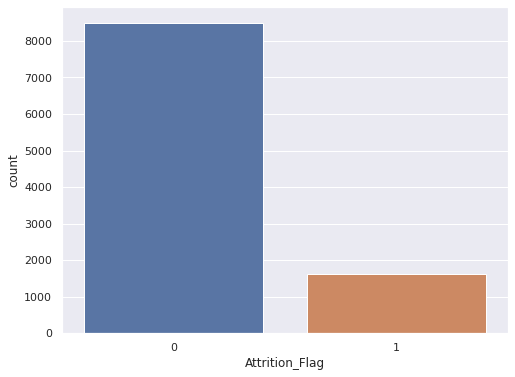

F    52.908068
M    47.091932
Name: Gender, dtype: float64


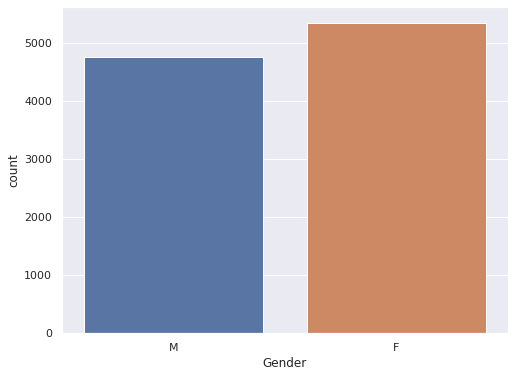

Graduate         30.887726
High School      19.877555
Unknown          14.999506
Uneducated       14.683519
College          10.002962
Post-Graduate     5.095290
Doctorate         4.453441
Name: Education_Level, dtype: float64


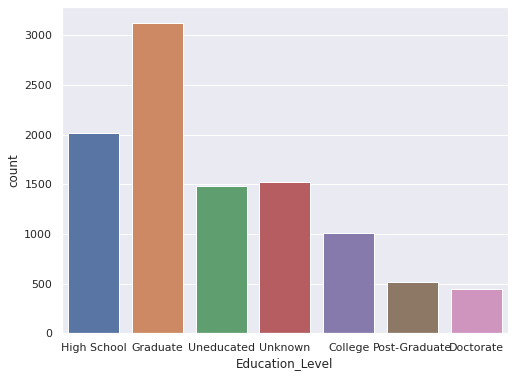

Married     46.282216
Single      38.935519
Unknown      7.396070
Divorced     7.386195
Name: Marital_Status, dtype: float64


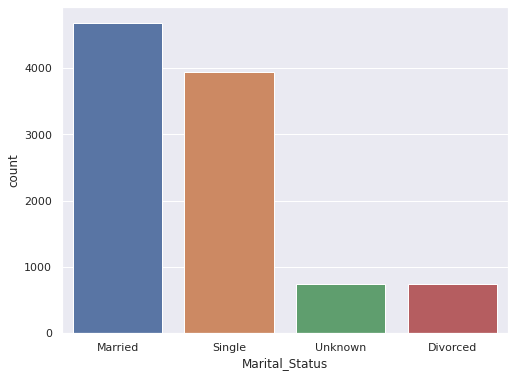

Less than $40K    35.163425
$40K - $60K       17.675521
$80K - $120K      15.157500
$60K - $80K       13.844179
Unknown           10.980547
$120K +            7.178829
Name: Income_Category, dtype: float64


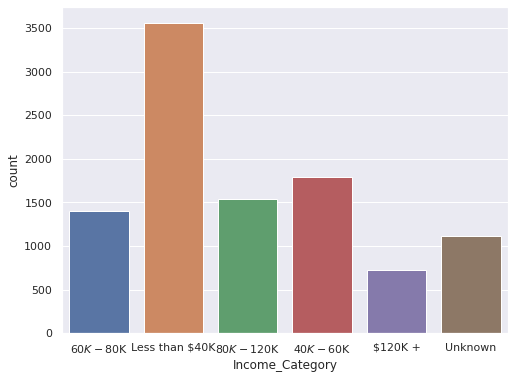

Blue        93.176656
Silver       5.480399
Gold         1.145453
Platinum     0.197492
Name: Card_Category, dtype: float64


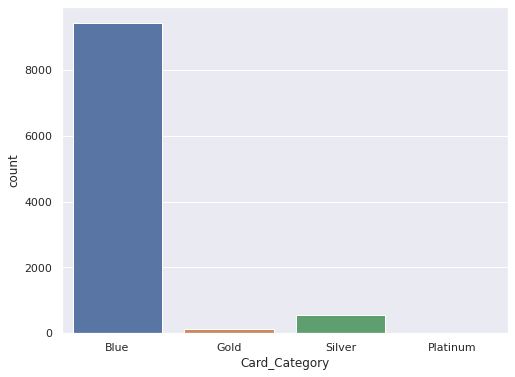

In [13]:
# Unique values of each categories

all_categories = ["Attrition_Flag",
                  "Gender",
                  "Education_Level",
                "Marital_Status",
                 "Income_Category",
                 "Card_Category"] 
for category in all_categories:
    print(df[category].value_counts(normalize=True)*100)
    plt.figure(figsize=(8,6))
    sns.countplot(df[category])
    plt.show()

**Remark [On categorical variables]:**

- [Attrition_Flag]- This is a target variable. 83.9% of the data are existing customers and 16.1% were attrited. This implies an imbalanced dataset.
- 52.9% of the customers were female and the rest were men.
- On education level, majority of the customers are graduates (30.9%) followed by high school leavers (19.9%). Doctorate fellows are the least in this grouping.
- 46.3% makes the married customers (the majority). Divorced customers are the least.
- Majority of customers earned less than 40K(35.16%) with only 7.17% earning above 120K.
- On card category, 93.2% holds Blue cards, followed by Silver(5.5%), then Gold(1.1%) and only 0.2% holding Platinum.

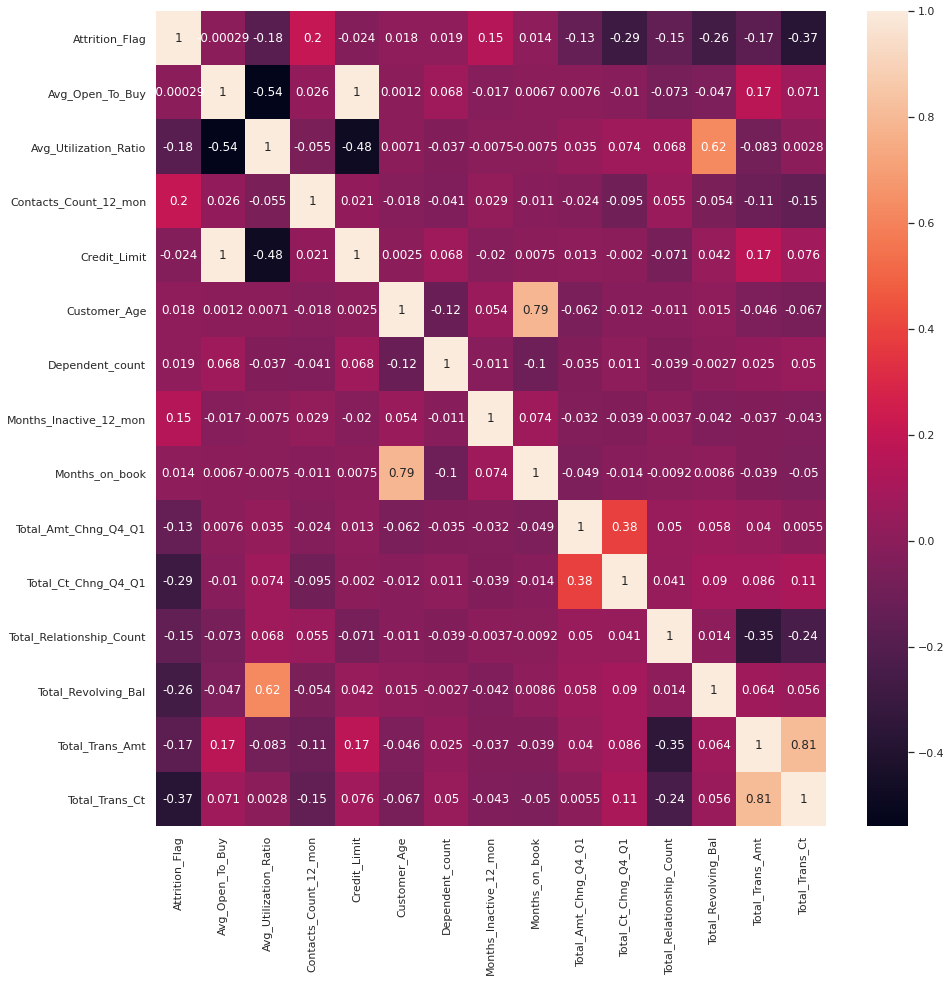

In [14]:
numerical_col = df.select_dtypes(include=np.number).columns.tolist()# getting list of numerical columns
unwanted_numeric = ["CLIENTNUM"]
numeric_cols = np.setdiff1d(numerical_col,unwanted_numeric)

plt.figure(figsize=(15,15))
df_corr = df[numeric_cols].corr()
sns.heatmap(df_corr, annot=True);

**Insight(correlation)**
- Total_Trans_Amt vs Total_Trans_Ct as expected that the more transaction count the more the transaction amount, these two variables have strong positive correlation at 0.81.
- Customer_Age and Months_on_book are strongly correlated at 0.79.
- Total_Revolving_Bal vs Avg_Utilization_Ratio, strong correlation with a value of 0.62.

In [15]:
# Our interest is on the Attrition Flag attribute and therefore we can filter
# correlation values concerning this attribute

# Taking absolute on the values because we are concerned with correlation of
# either end
df_corr["Attrition_Flag"].abs().sort_values(ascending=False)


Attrition_Flag              1.000000
Total_Trans_Ct              0.371403
Total_Ct_Chng_Q4_Q1         0.290054
Total_Revolving_Bal         0.263053
Contacts_Count_12_mon       0.204491
Avg_Utilization_Ratio       0.178410
Total_Trans_Amt             0.168598
Months_Inactive_12_mon      0.152449
Total_Relationship_Count    0.150005
Total_Amt_Chng_Q4_Q1        0.131063
Credit_Limit                0.023873
Dependent_count             0.018991
Customer_Age                0.018203
Months_on_book              0.013687
Avg_Open_To_Buy             0.000285
Name: Attrition_Flag, dtype: float64

Remarks:

- The relationship of the above features (individually) with Attrition is generally weak

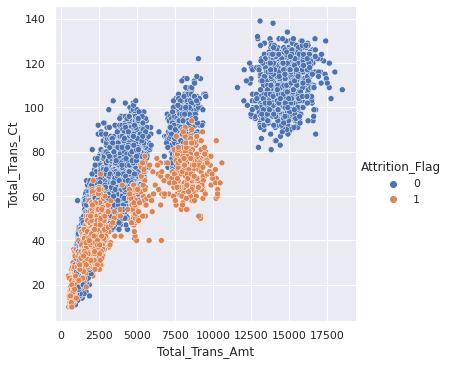

In [16]:
sns.relplot(data=df, kind='scatter', \
            x='Total_Trans_Amt', y='Total_Trans_Ct',hue='Attrition_Flag');

Remarks: 

- The correleation between features: Total_Trans_Ct and Total_Trans_Amt needed a deeper insight in relation to the target feature (Attrition_Flag).
- Customers with larger total number of transactions had tendency to spend more and then keep using credit card services.   
    

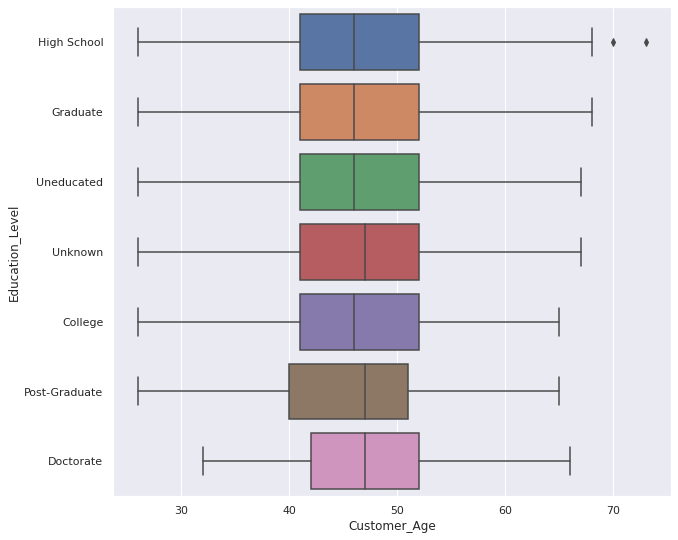

In [17]:
# lets see how working hours per week vary across different occupation
plt.figure(figsize=(10,9))
sns.boxplot(y="Education_Level", x="Customer_Age", data=df);

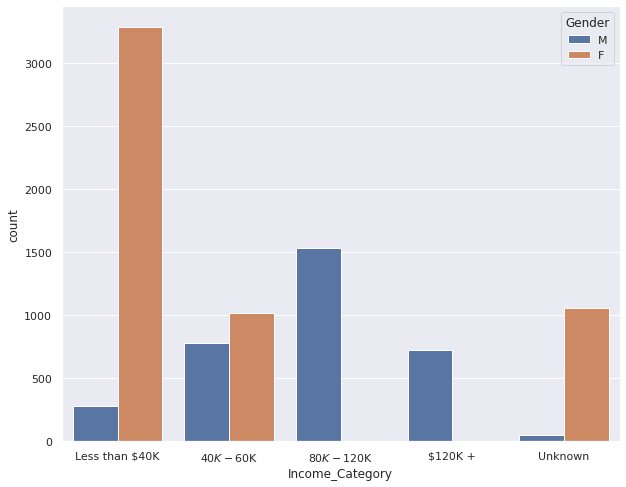

In [18]:
plt.figure(figsize=(10,8))
sns.countplot(df.Income_Category, hue=df.Gender,\
              order=["Less than $40K","$40K - $60K","$80K - $120K","$120K +","Unknown"]);

Comments:

- Females are dominant in the lowest category of income, that is $40 and below.

- The majority of males are earning between $80K  to  $120K

Education_Level  College  Doctorate  Graduate  High School  Post-Graduate  \
Income_Category                                                             
$120K +               70         37       204          147             30   
$40K - $60K          183         70       553          355            111   
$60K - $80K          132         59       422          307             77   
$80K - $120K         175         57       478          308             81   
Less than $40K       345        158      1139          671            170   
Unknown              108         70       332          225             47   
All                 1013        451      3128         2013            516   

Education_Level  Uneducated  Unknown    All  
Income_Category                              
$120K +                 119      120    727  
$40K - $60K             249      269   1790  
$60K - $80K             195      210   1402  
$80K - $120K            217      219   1535  
Less than $40K          522   

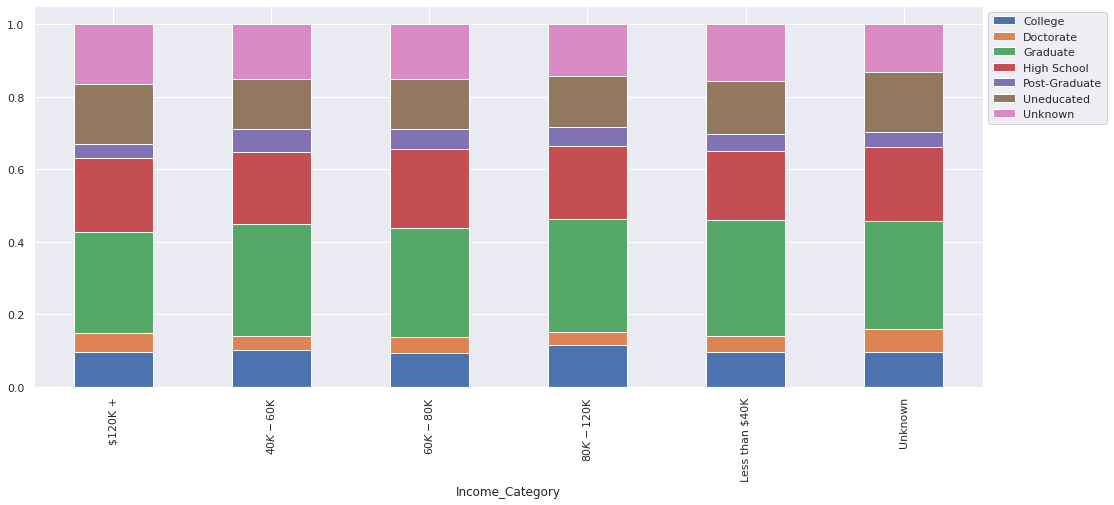

In [19]:
tab1 = pd.crosstab(df.Income_Category,df.Education_Level,margins=True)
print(tab1)
print('-'*100)
tab = pd.crosstab(df.Income_Category,df.Education_Level,normalize='index')
tab.plot(kind='bar',stacked=True,figsize=(17,7))
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

Comments:

- Its appears that there is no trend or critical insight observable between the level of education when compared with categories of income.

Gender              F     M    All
Education_Level                   
College           532   481   1013
Doctorate         257   194    451
Graduate         1670  1458   3128
High School      1028   985   2013
Post-Graduate     263   253    516
Uneducated        796   691   1487
Unknown           812   707   1519
All              5358  4769  10127
----------------------------------------------------------------------------------------------------


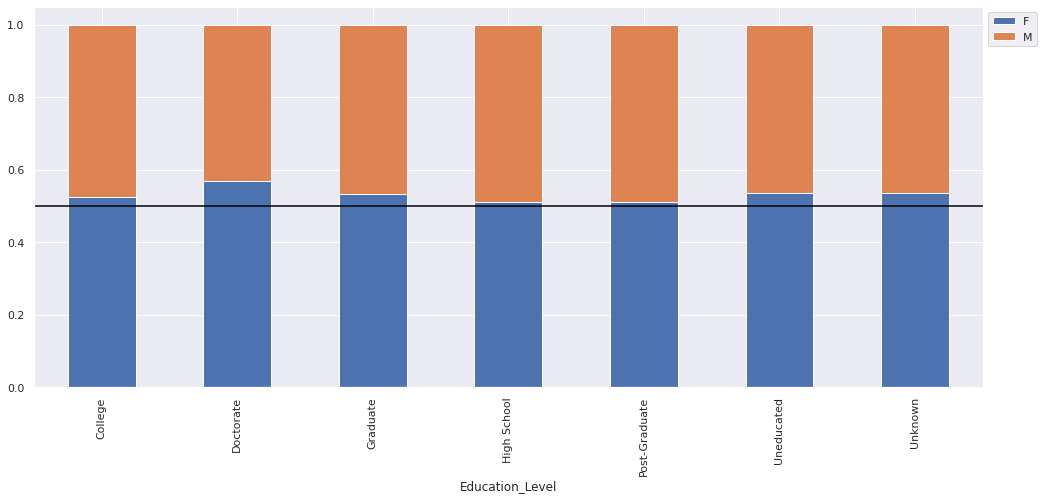

In [20]:
tab1 = pd.crosstab(df.Education_Level,df.Gender,margins=True)
print(tab1)
print('-'*100)
tab = pd.crosstab(df.Education_Level,df.Gender,normalize='index')
tab.plot(kind='bar',stacked=True,figsize=(17,7))
plt.axhline(0.5, color="black")
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

Comments:

- Educationally, it appears that females are slightly more educated than men generally.

  More specifically: 
  

- In the educational level: Doctorate, females are clearly more than men (57%).

- Females are also little above men under educational level: uneducated (53%).


Attrition_Flag      0     1    All
Education_Level                   
College           859   154   1013
Doctorate         356    95    451
Graduate         2641   487   3128
High School      1707   306   2013
Post-Graduate     424    92    516
Uneducated       1250   237   1487
Unknown          1263   256   1519
All              8500  1627  10127
----------------------------------------------------------------------------------------------------


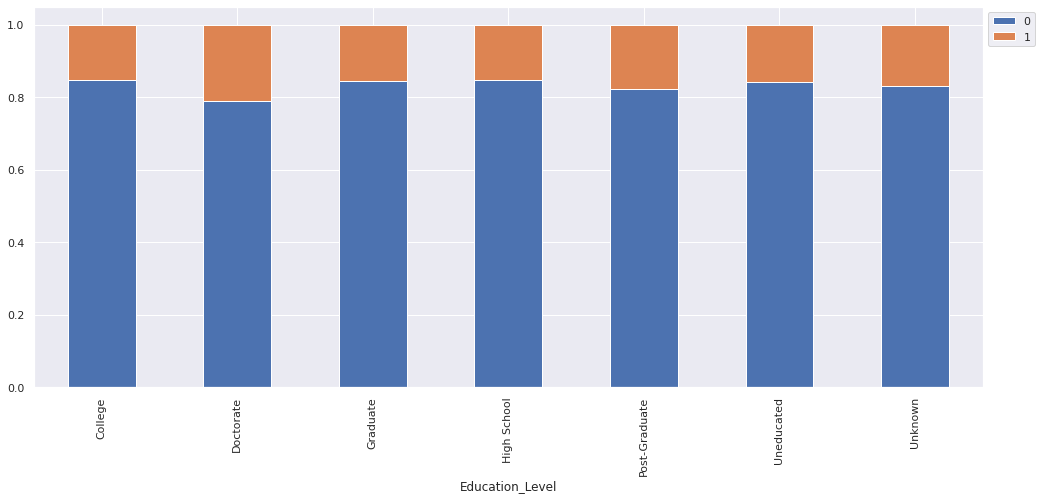

In [21]:
tab1 = pd.crosstab(df.Education_Level,df.Attrition_Flag,margins=True)
print(tab1)
print('-'*100)
tab = pd.crosstab(df.Education_Level,df.Attrition_Flag,normalize='index')
tab.plot(kind='bar',stacked=True,figsize=(17,7))
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

Observation: 

- Across all levels of education, customers close their account in huge numbers (e.g +/-80% of customers had kept using credit card services across all levels of education) 

- The analysis also to suggest that being a credit card holder had nothing to do with the level of education - particularly when it comes to a decision whether to hold-on to credit account or close it. 

- Moreover, this also suggest that the problem or unhappiness with the bank's credit account is equally experience across the all customers irrespective of their levels of education. 

- Clearly, the bank has to take drastic measures to reserve the trend if the credit card services are still viewed a crucial revenue source to the bank. 




Attrition_Flag     0     1    All
Card_Category                    
Blue            7917  1519   9436
Gold              95    21    116
Platinum          15     5     20
Silver           473    82    555
All             8500  1627  10127
------------------------------------------------------------------------------------------------------------------------


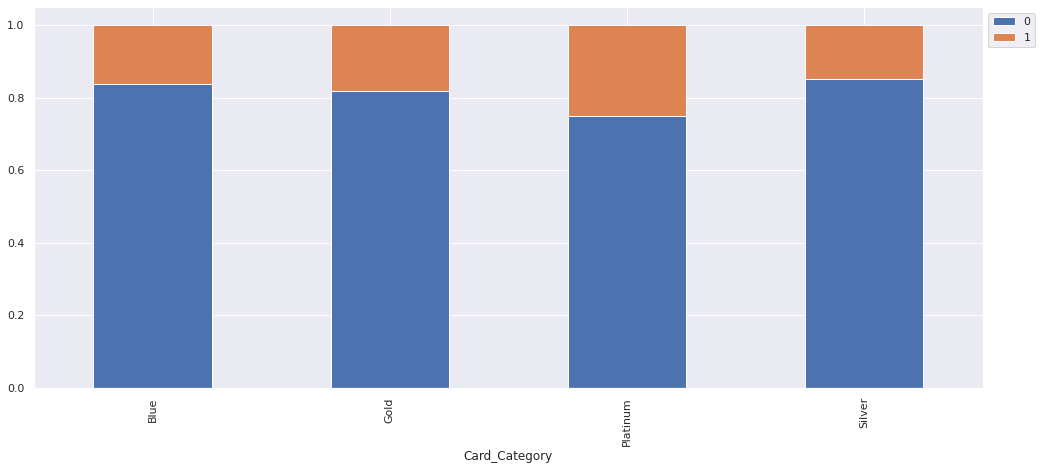

In [22]:
tab1 = pd.crosstab(df.Card_Category,df.Attrition_Flag,margins=True)
print(tab1)
print('-'*120)
tab = pd.crosstab(df.Card_Category,df.Attrition_Flag,normalize='index')
tab.plot(kind='bar',stacked=True,figsize=(17,7))
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

Observation: 
    
- Irrespective of product type (Card_Category), card holders had closed their account in similar trends across all product types. +/- 80 customers had kept using credit cards services across all card categories.

- Card_Category trends are similar to those observable under educational levels. 

Attrition_Flag     0     1    All
Gender                           
F               4428   930   5358
M               4072   697   4769
All             8500  1627  10127
----------------------------------------------------------------------------------------------------


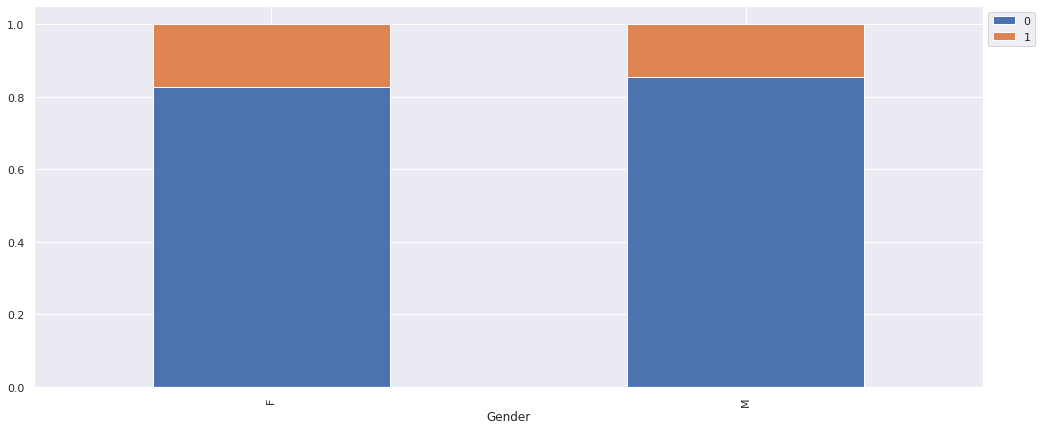

In [23]:
tab1 = pd.crosstab(df.Gender,df.Attrition_Flag,margins=True)
print(tab1)
print('-'*100)
tab = pd.crosstab(df.Gender,df.Attrition_Flag,normalize='index')
tab.plot(kind='bar',stacked=True,figsize=(17,7))
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

Remarks:

- Both males and females had left credit card services in huge numbers.

- More than 80% of credit card holders, across all gender types, had kept using credit card accounts.  
    

<Figure size 1080x648 with 0 Axes>

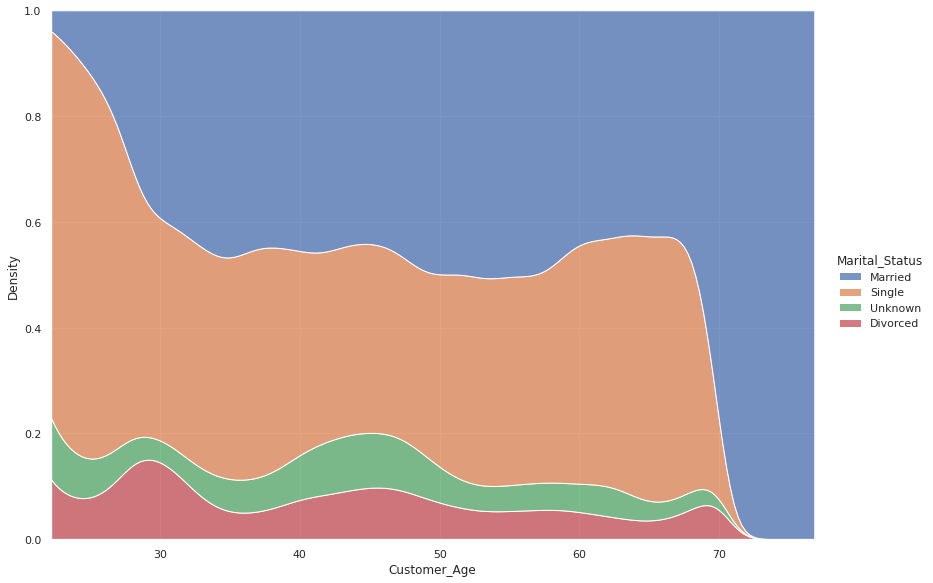

In [24]:
# lets us look at normalized chart of age vs marital status
plt.figure(figsize=(15,9))
sns.displot(
    data=df,
    x="Customer_Age", hue="Marital_Status",
    kind="kde", #height=6,
    multiple="fill", #clip=(0, None),
    #palette="ch:rot=-.25,hue=1,light=.75"
    height=8.27, aspect=11.7/8.27
);

Remarks: 
    
No insightful observation.

<AxesSubplot:xlabel='Customer_Age', ylabel='Density'>

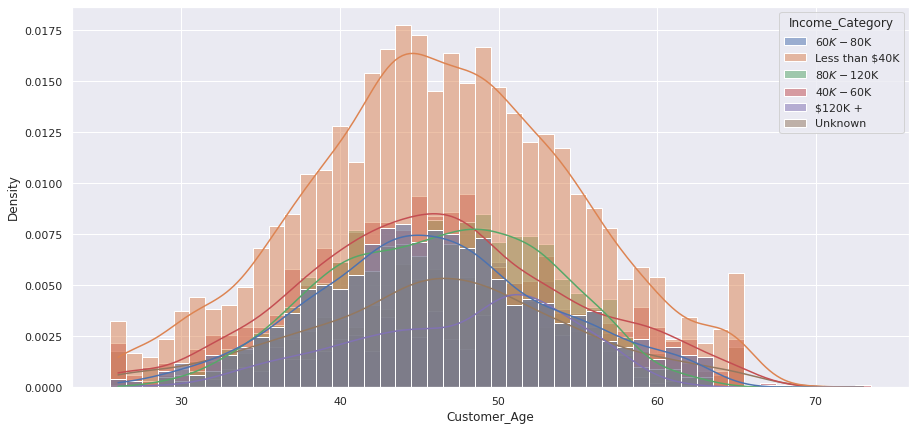

In [25]:
plt.figure(figsize=(15,7))
sns.histplot(df, x="Customer_Age", hue="Income_Category",stat='density',kde=True,discrete=True)

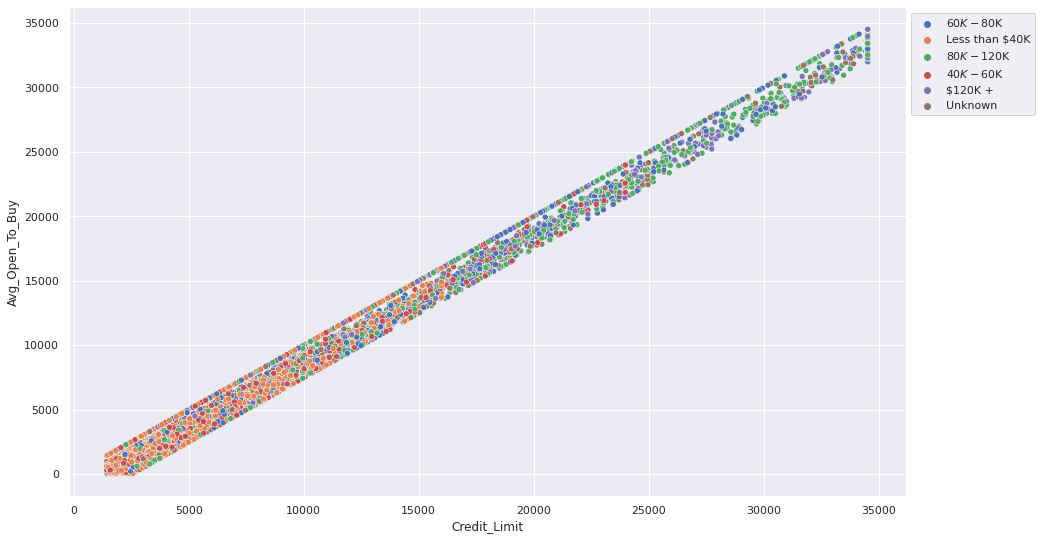

In [26]:
plt.figure(figsize=(15,9))
sns.scatterplot(x=df.Credit_Limit,y=df.Avg_Open_To_Buy,hue=df.Income_Category)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

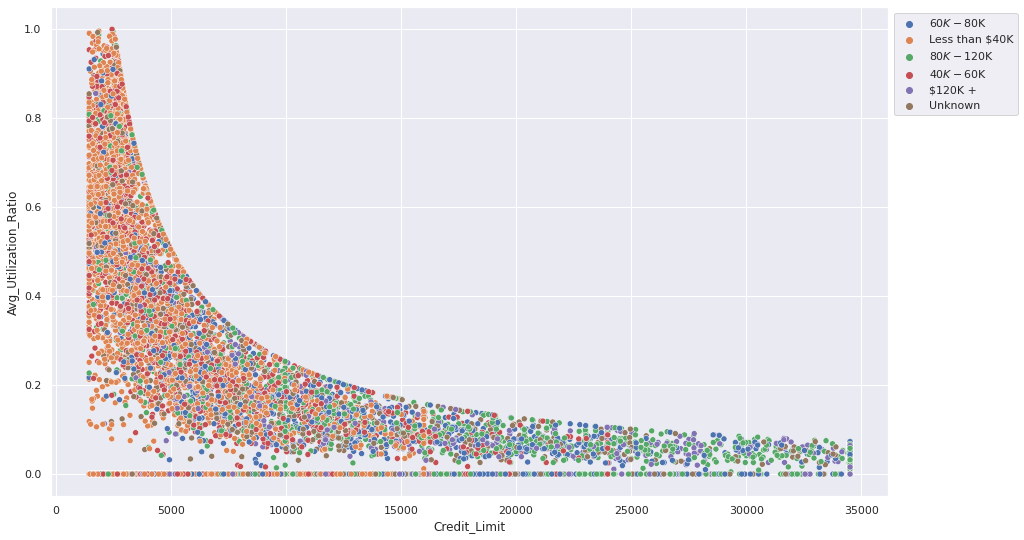

In [27]:
plt.figure(figsize=(15,9))
sns.scatterplot(x=df.Credit_Limit,y=df.Avg_Utilization_Ratio,hue=df.Income_Category)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

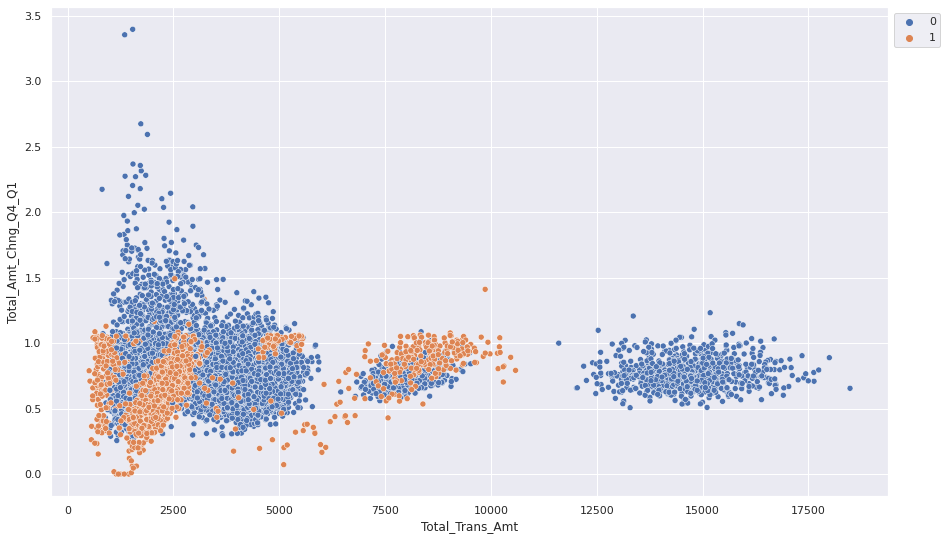

In [28]:
plt.figure(figsize=(15,9))
sns.scatterplot(x=df.Total_Trans_Amt,y=df.Total_Amt_Chng_Q4_Q1,hue=df.Attrition_Flag)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

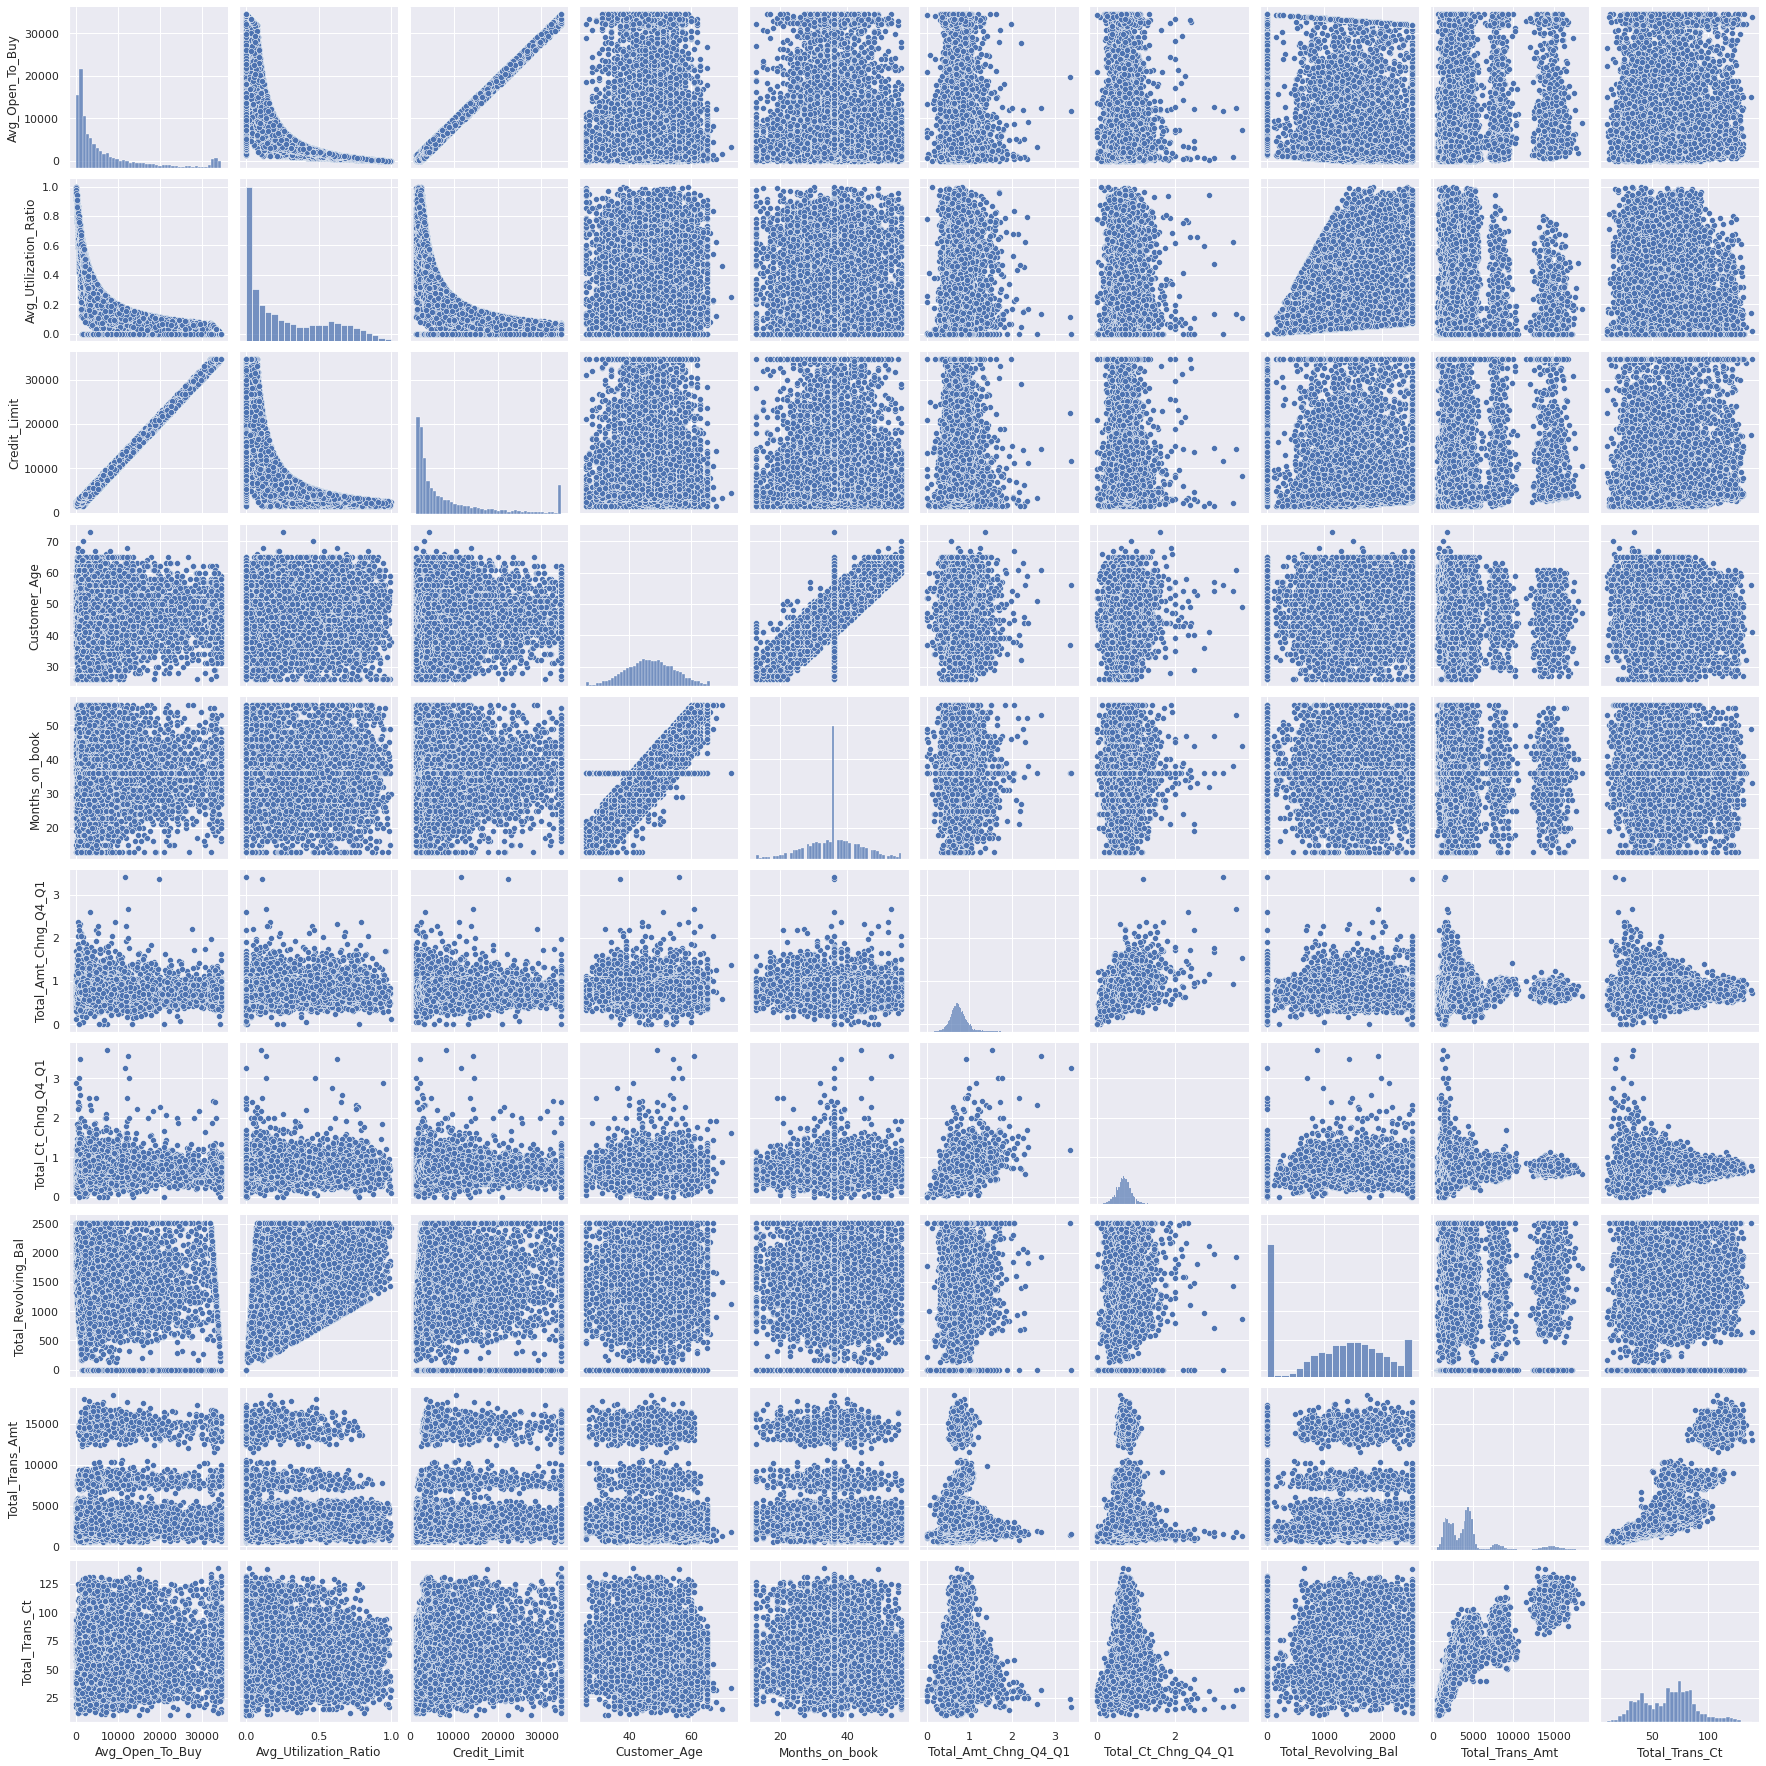

In [29]:
numeric_cols2 = np.setdiff1d(numeric_cols,\
                             ["Attrition_Flag","Dependent_count","Months_Inactive_12_mon",\
                              "Total_Relationship_Count","Contacts_Count_12_mon"])
sns.pairplot(df[numeric_cols2])

In [30]:
# Function to plot histogram and boxplot for numerical variables as we study the 
# central tendency and dispersion for such values
def histogram_boxplot(feature, figsize=(10,8), bins = None):
    """ 
    Boxplot and histogram combined with shared axis
    feature: 1-d feature array
    figsize: size of fig (default (10,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

Avg_Open_To_Buy ,Skew 1.66


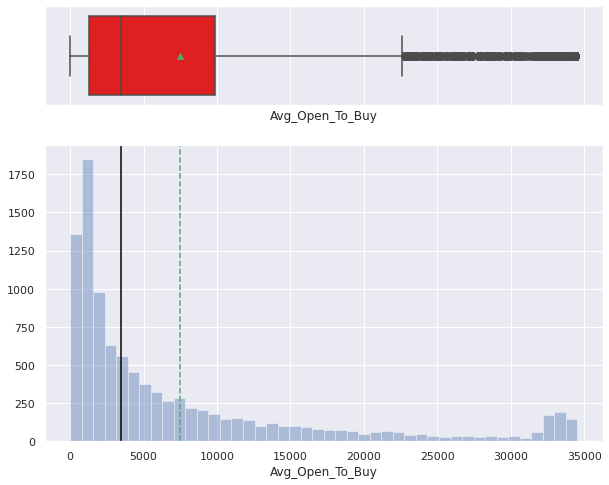

Avg_Utilization_Ratio ,Skew 0.72


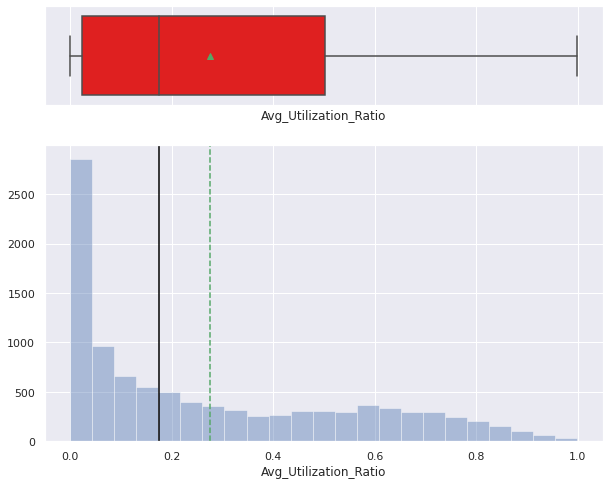

Contacts_Count_12_mon ,Skew 0.01


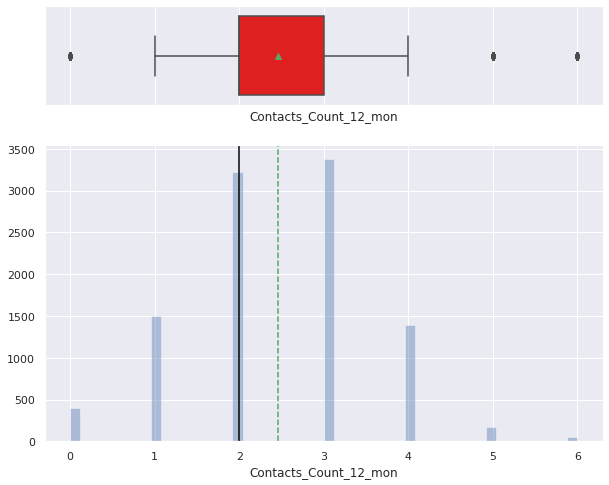

Credit_Limit ,Skew 1.67


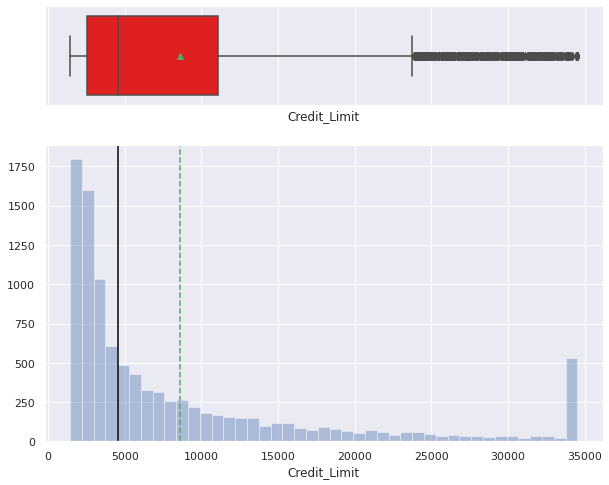

Customer_Age ,Skew -0.03


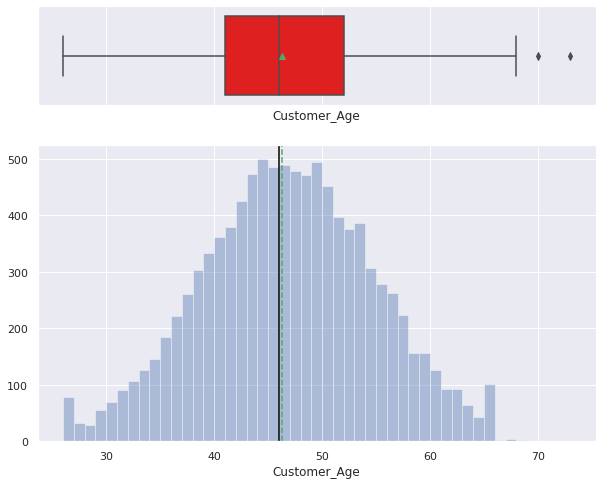

Dependent_count ,Skew -0.02


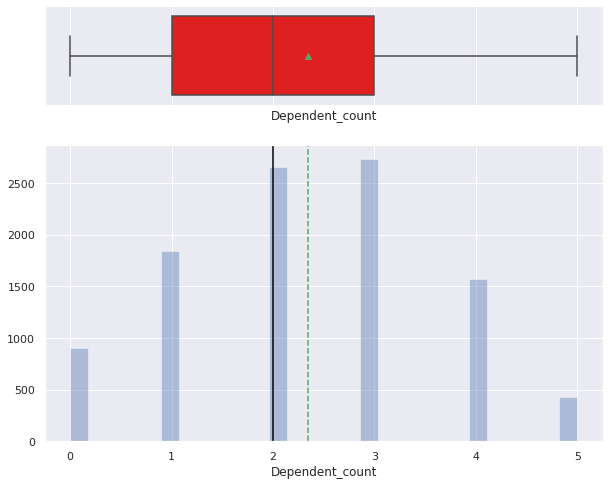

Months_Inactive_12_mon ,Skew 0.63


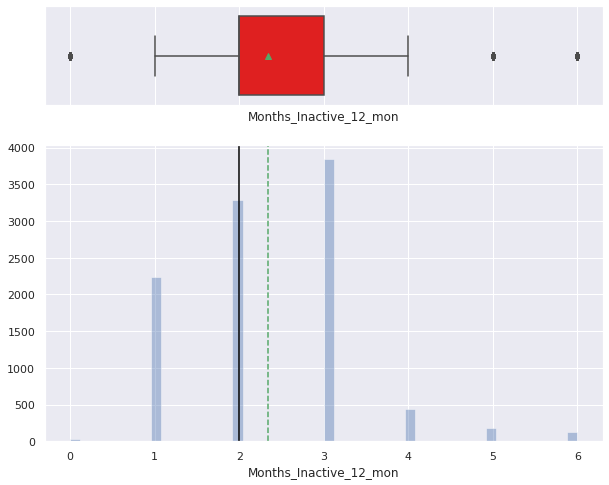

Months_on_book ,Skew -0.11


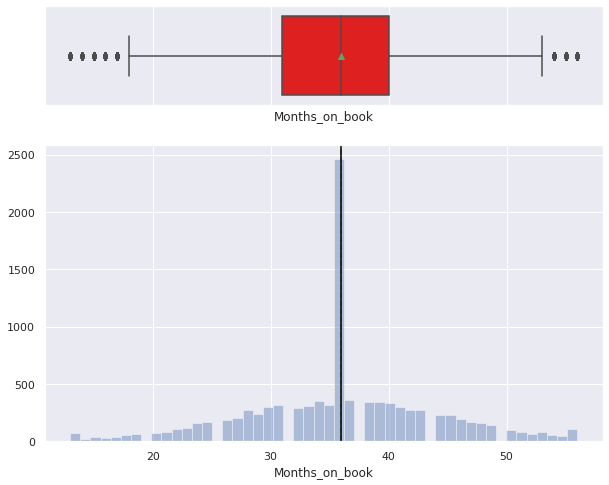

Total_Amt_Chng_Q4_Q1 ,Skew 1.73


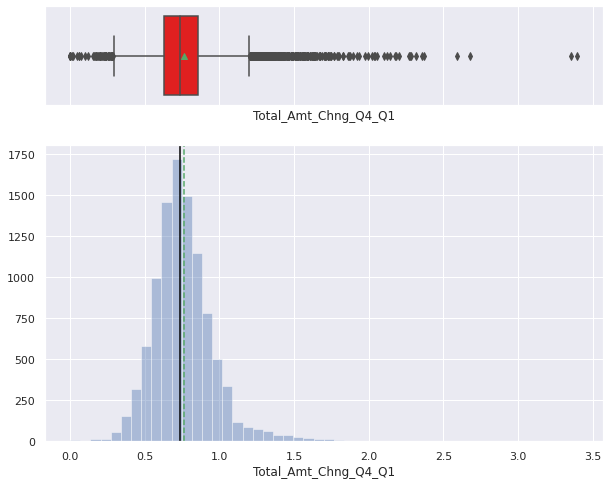

Total_Ct_Chng_Q4_Q1 ,Skew 2.06


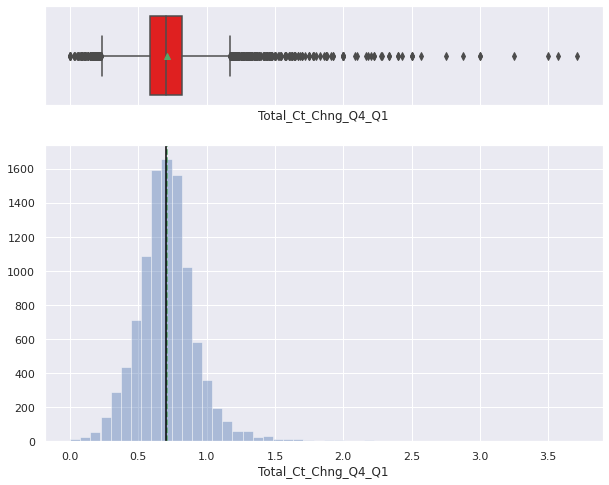

Total_Relationship_Count ,Skew -0.16


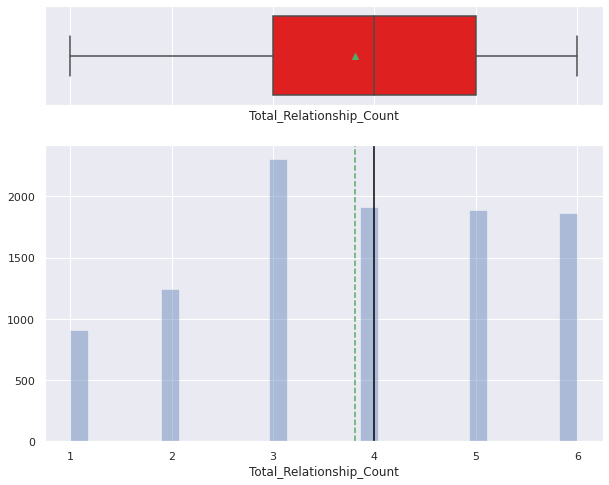

Total_Revolving_Bal ,Skew -0.15


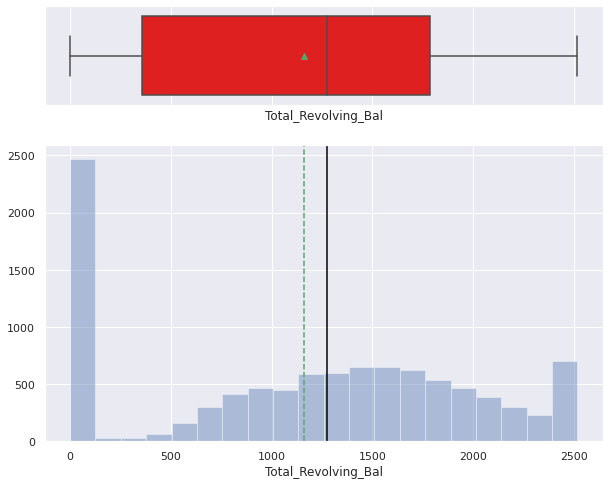

Total_Trans_Amt ,Skew 2.04


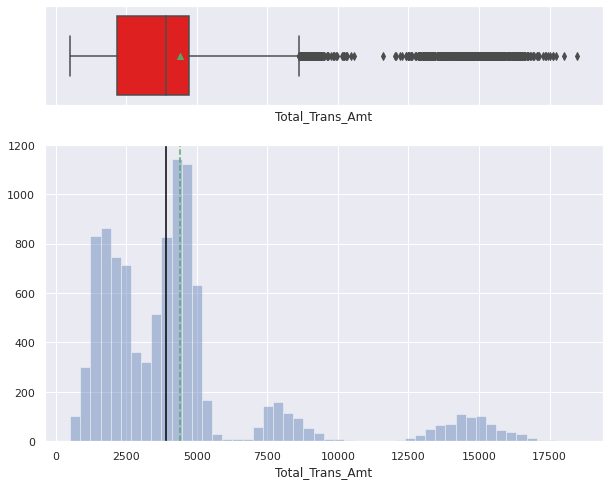

Total_Trans_Ct ,Skew 0.15


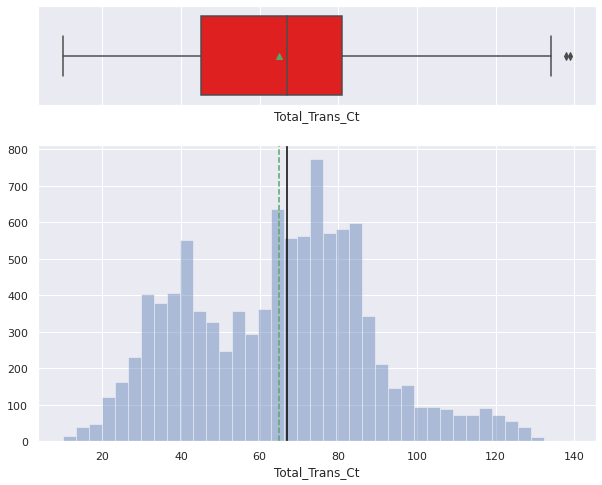

In [31]:
num_cols = list(df.select_dtypes(np.number).columns)
# num_cols.remove("CLIENTNUM").remove("Attrition_Flag")
num_cols = np.setdiff1d(num_cols, ["CLIENTNUM","Attrition_Flag"])
for col in num_cols:
    print(col,",Skew", round(df[col].skew(),2))
    histogram_boxplot(feature=df[col])
    plt.show()

**Comments[Skewness, outliers, descriptive statistics]**
- Customer_Age is not skewed but has few upper outliers.
- Months_on_book is not skewed but with both upper and lower outliers.
- Months_Inactive_12_mon slightly skewed to the right with outliers to both ends.
- Credit_Limit is highly skewed to the right with so many upper outliers.
- Total_Revolving_Bal - almost 2500 customers have zero balance.
- Avg_Open_To_Buy - highly skewed to the right with upper outliers.
- Total_Amt_Chng_Q4_Q1 - skewed to the right with both upper and lower outliers.
- Total_Trans_Amt has some grouping of some sort on distribution but the attributed is skewed to the right  with alot of upper outliers.
- Total_Ct_Chng_Q4_Q1 with most outliers in the upper end and a few on the lower. Skewed to the right.

# DATA PROCESSING AND FEATURE ENGINEERING

In [32]:
# A function to treat outliers.
# Replace upper outliers with value of upper whisker and replace lower outliers with value of lower whisker.
def treat_outliers(df, cols):
    '''
    treats outliers in the columns cols
    cols - columns we want to treat,
    df - the dataframe
    '''
    for col in cols:
        Q1=df[col].quantile(0.25) # 25th quantile
        Q3=df[col].quantile(0.75)  # 75th quantile
        IQR=Q3-Q1
        Lower_Whisker = Q1 - 1.5*IQR 
        Upper_Whisker = Q3 + 1.5*IQR
        df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df
    

In [33]:
# Treat outliers for columns with outliers
df = treat_outliers(df,num_cols)

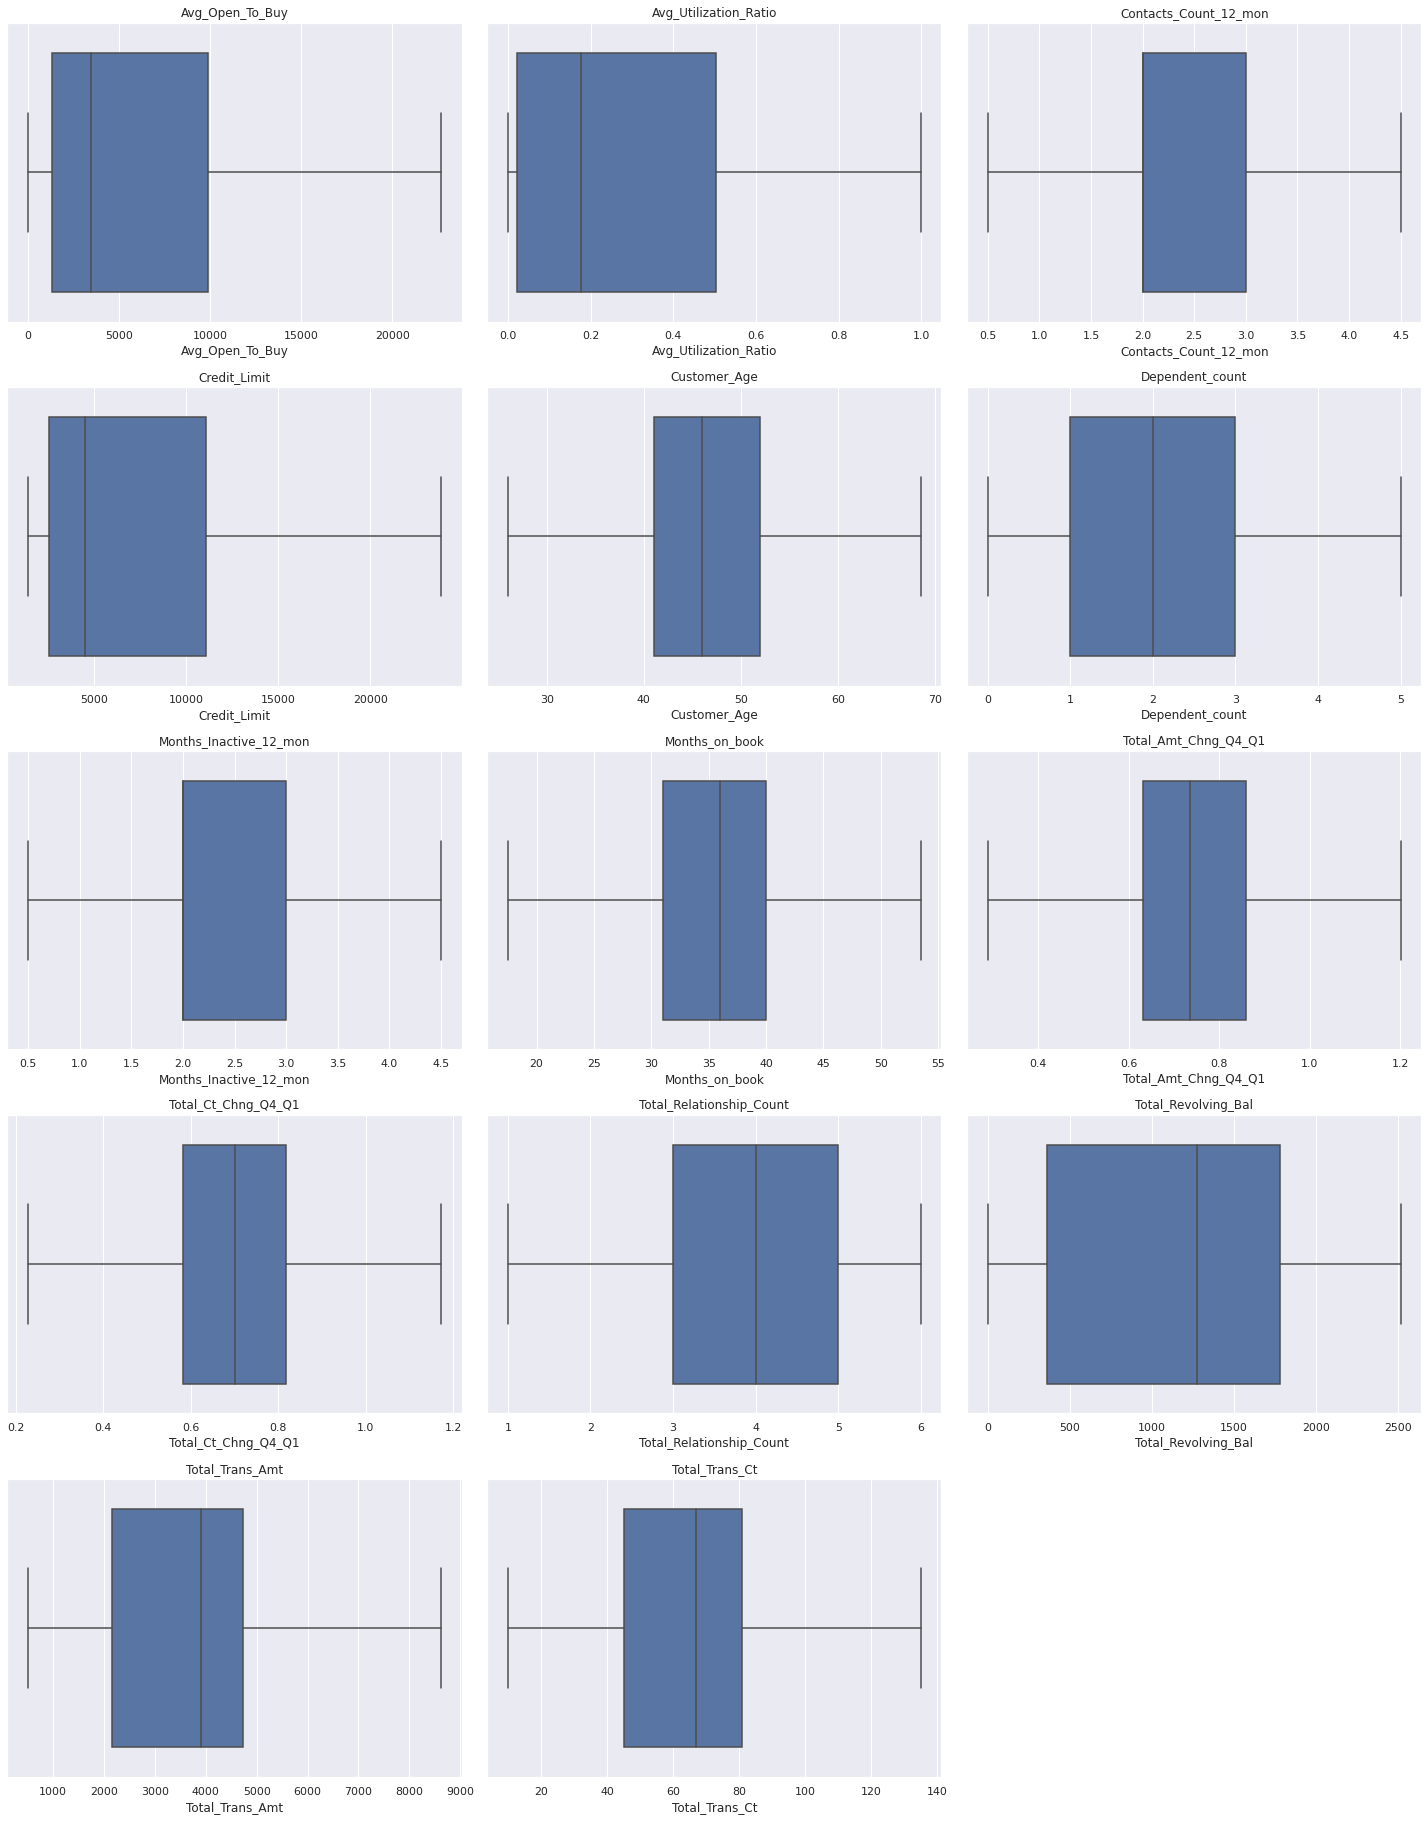

In [34]:
# Check that outliers has been treated boxplot
plt.figure(figsize=(20,30))
for i, variable in enumerate(num_cols):
    plt.subplot(6,3,i+1)
    sns.boxplot(df[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

# No more outliers

**Remarks (On treating outliers and missing values):**

- Numeric features with outliers were treated by replacing lower outliers with lower whisker value and replace upper outliers with upper whisker value. 
- On the original data, the following feature columns was found to contain outliers: Customer_Age, Months_on_book, Credit_Limit, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1 among other attributes.
- Before and after treating outliers, we used Boxplot to check the presence of outliers and to confirm that outliers were actually treated.

In [35]:
# Replacing ordinal columns - columns with rank of some sort
replaceStruct = {
    "Card_Category": {
                          "Blue": 4, 
                          "Silver": 3, 
                          "Gold": 2, 
                          "Platinum": 1
                    },
    "Education_Level": {
                            "Unknown": -1, 
                            "Uneducated": 5,
                            "High School": 4,
                            "College": 3,
                            "Graduate": 2,
                            "Post-Graduate":1,
                            "Doctorate": 0
                       },
    "Income_Category": {
                            "Unknown": -1,
                            "Less than $40K": 4,
                            "$40K - $60K": 3,
                            "$60K - $80K": 2,
                            "$80K - $120K": 1,
                            "$120K +": 0
                        }
}

# Nominal columns that will be encoded with One-Hot encoding
one_hot = ["Marital_Status", "Gender"]

In [36]:
# Replace values on ordinal columns with values shown above
df.replace(replaceStruct, inplace=True)
# One hot encoding
df = pd.get_dummies(df, columns=one_hot)

In [37]:
df.head(2)

CLIENTNUM  Attrition_Flag  Customer_Age  Dependent_count  Education_Level  \
0  768805383               0          45.0                3                4   
1  818770008               0          49.0                5                2   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count  \
0                2              4            39.0                         5   
1                4              4            44.0                         6   

   Months_Inactive_12_mon  ...  Total_Trans_Amt  Total_Trans_Ct  \
0                     1.0  ...           1144.0              42   
1                     1.0  ...           1291.0              33   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Marital_Status_Divorced  \
0                1.172                  0.061                        0   
1                1.172                  0.105                        0   

   Marital_Status_Married  Marital_Status_Single  Marital_Status_Unknown  \
0                       1                      0                       0   
1                       0                      1                       0   

   Gender_F  Gender_M  
0         0         1  
1         1         0  

[2 rows x 25 columns]

**Attempt [Tried and failed]:** Using mid-point values for the income instead of the ordinal values
 did not help to improve the models so we will not pursue that option.

# MODEL BUILDING

In [38]:
# Client number are unique identifies. It will not help us 
# improve our model performance
df.drop(["CLIENTNUM"], axis=1, inplace=True)

### On metrics
We will calculate 4 metrics - Accuracy, Precision, Recall and F1  but the metric of interest here is recall but the customers .

Recall refers to the percentage of your results which are relevant given all instances. That translate to identifying attrited customers in the dataset. Hyperparameters will, therefore, be tuned using recall_score

### Spliting data into 3 sets using numpy split function - training, validation and testing sets

- Training set will be used to train the model, validation for tuning hyperparameters and test set for testing the model to see how it will perfom in production.
- train_test_split function from sklearn.model_selection cannot be used here because it only splits data into train and test sets.
- We also need to sample the two classes with the proportion in original data. This is synonymous to statify=y for train_test_split. As shown below the original data has 83.9% were existing customers and 16.1% were attrited. We will maintain this proportion on data splits.

In [39]:
df_original["Attrition_Flag"].value_counts(normalize=True)*100

Existing Customer    83.934038
Attrited Customer    16.065962
Name: Attrition_Flag, dtype: float64

In [40]:
# filter existing customers (class 0) and attrited (class 1)
df_class0 = df.loc[df["Attrition_Flag"]==0]
df_class1 = df.loc[df["Attrition_Flag"]==1]

# Shuffle data in each other class and split them into 3 at 60-20-20 rule
train_class0, val_class0, test_class0 = \
              np.split(df_class0.sample(frac=1, random_state=42), 
                       [int(0.6*len(df_class0)), int(0.8*len(df_class0))])

train_class1, val_class1, test_class1 = \
              np.split(df_class1.sample(frac=1, random_state=42), 
                       [int(0.6*len(df_class1)), int(0.8*len(df_class1))])

# Join the sets in each class and shuffle them one more time to have the train
# validation and test sets
train = pd.concat([train_class0, train_class1])
val = pd.concat([val_class0, val_class1])
test = pd.concat([test_class0,test_class1])

# Check proportion of the two classes in each set:
print(dict(train["Attrition_Flag"].value_counts(normalize=True)*100))
print(dict(val["Attrition_Flag"].value_counts(normalize=True)*100))
print(dict(test["Attrition_Flag"].value_counts(normalize=True)*100))

# Extract target and features from each set
X_train, y_train = train.drop(['Attrition_Flag'], axis=1), train['Attrition_Flag']
X_val, y_val = val.drop(['Attrition_Flag'], axis=1), val['Attrition_Flag']
X_test, y_test = test.drop(['Attrition_Flag'], axis=1), test['Attrition_Flag']

{0: 83.93680052666228, 1: 16.063199473337722}
{0: 83.9506172839506, 1: 16.049382716049383}
{0: 83.90918065153011, 1: 16.090819348469893}


**Remark**
- Success! We have managed to split the dataset and maintain the proportion in the dataset.

In [41]:
# Displaying shapes for each set split 
# Train -60%, val-20% and test-20%
print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape",y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape",y_test.shape)

X_train shape (6076, 23)
y_train shape (6076,)
X_val shape (2025, 23)
y_val shape (2025,)
X_test shape (2026, 23)
y_test shape (2026,)


In [42]:
# Keeping all the model performance results here
model_results = []

In [43]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def GetScores(model,model_name=None,time_taken=None):
    '''
    This function is used to make prediction and to determine model
    performance using metrics like: accuracy, precision, recall and f1.

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    val_acc = model.score(X_val,y_val)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = recall_score(y_train,pred_train)
    val_recall = recall_score(y_val,pred_val)
    test_recall = recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = precision_score(y_train,pred_train)
    val_precision = precision_score(y_val,pred_val)
    test_precision = precision_score(y_test,pred_test)
    
    #Precision of the model
    train_f1 = f1_score(y_train,pred_train)
    val_f1 = f1_score(y_val,pred_val)
    test_f1 = f1_score(y_test,pred_test)
        
    # Model is defined explicitly as function argument or derived from model object as below
    if model_name is None:
        # extract model name from model object
        model_name = str(model).split("(")[0]
        # Tuned and models with default parameters may have the same name.
        # Generate ext random string and concatinate with the name to make it unique
        # ext variable is global so that it can be used by ConfusionMatrix function
        global ext
        ext = "".join(random.sample("abcdefghijklmneuiqyriur0peq9r69829246rmpf930479bc",3))
        model_name = model_name +"_"+ext
        
    # results to return
    results = {
        "model_name":model_name,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc":test_acc,
        "train_recall": train_recall,
        "val_recall": val_recall,
        "test_recall": test_recall,
        "train_precision": train_precision,
        "val_precision": val_precision,
        "test_precision": test_precision,
        "train_f1": train_f1,
        "val_f1": val_f1,
        "test_f1": test_f1,
        "execution_time": time_taken
    }
    
    # To save results to a list for comparison purposes later.
    try:
        done = [i["model_name"] for i in model_results]
    except KeyError as e:
        model_results.append(results)
        done = [i["model_name"] for i in model_results]
    if model_name not in done:
        model_results.append(results)
    else:
        print("Caught up")
        
    # Formating Python dictionary using JSON library
    print(json.dumps(results, indent=3))
    
    # returning the scores in dictionary formart
    return results 

In [44]:
## Function to create confusion matrix
def ConfusionMatrix(model,y_actual,set1,labels=[0, 1], model_name = None, save_as=None):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    set1 is train, val or test. 
    model_name is the model name that will be used as reference later
    save_as is the plot name if the plot has to be saved
    
    '''
    # set1 must be either "train", "val" or test otherwise raise an errot
    assert set1 in ["train","val","test"], \
    "set1 can only take one of these values 'train', 'val' or 'test'"
    if model_name is None:
        model_name = str(model).split("(")[0]
        model_name = model_name +"_"+ ext
        
    
    
    if set1 == "test":
        # Just to catch that the y_actual passed are actually that of test set
        assert len(X_test)==len(y_actual),\
        "check that you passed y_actual for test set or fix set1 value"
        y_predict = model.predict(X_test)
        cm=metrics.confusion_matrix( y_actual, y_predict, labels=[1, 0])
        df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - Attrited","Actual - Existing"]],
                      columns = [i for i in ['Predicted - Attrited','Predicted - Existing']])
        group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}" for v1, v2 in
                  zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize = (10,7))
        sns.heatmap(df_cm, annot=labels,fmt='')

        plt.title("Confusion Matrix for {} set. Model:{}".format(set1,model_name))
        plt.ylabel('True label')
        plt.xlabel('Predicted label') 

        # Save the plot is need be
        if save_as != None:
            if not os.path.exists("images"):
                os.mkdir("images")
            plt.savefig("./images/{}_{}".format(set1, save_as))

        # Display the plot
        plt.show()
    elif set1 == "val":
        assert len(X_val)==len(y_actual),\
        "check that you passed y_actual for val set or fix set1 value"
        y_predict = model.predict(X_val)
        cm=metrics.confusion_matrix( y_actual, y_predict, labels=[1, 0])
        df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - Attrited","Actual - Existing"]],
                      columns = [i for i in ['Predicted - Attrited','Predicted - Existing']])
        group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}" for v1, v2 in
                  zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize = (10,7))
        sns.heatmap(df_cm, annot=labels,fmt='')

        plt.title("Confusion Matrix for {} set. Model:{}".format(set1,model_name))
        plt.ylabel('True label')
        plt.xlabel('Predicted label') 

        # Save the plot is need be
        if save_as != None:
            if not os.path.exists("images"):
                os.mkdir("images")
            plt.savefig("./images/{}_{}".format(set1, save_as))

        # Display the plot
        plt.show()
    else :
        assert len(X_train)==len(y_actual),\
        "check that you passed y_actual for train set or fix set1 value"
        y_predict = model.predict(X_train)
        cm=metrics.confusion_matrix( y_actual, y_predict, labels=[1, 0])
        df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - Attrited","Actual - Existing"]],
                      columns = [i for i in ['Predicted - Attrited','Predicted - Existing']])
        group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}" for v1, v2 in
                  zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize = (10,7))
        sns.heatmap(df_cm, annot=labels,fmt='')

        plt.title("Confusion Matrix for {} set. Model:{}".format(set1,model_name))
        plt.ylabel('True label')
        plt.xlabel('Predicted label') 

        # Save the plot is need be
        if save_as != None:
            if not os.path.exists("images"):
                os.mkdir("images")
            plt.savefig("./images/{}_{}".format(set1, save_as))

        # Display the plot
        plt.show()

## Decision Tree tuned - default parameters

{
   "model_name": "Decision Tree Default",
   "train_acc": 1.0,
   "val_acc": 0.9353086419753086,
   "test_acc": 0.9313919052319842,
   "train_recall": 1.0,
   "val_recall": 0.7907692307692308,
   "test_recall": 0.8128834355828221,
   "train_precision": 1.0,
   "val_precision": 0.803125,
   "test_precision": 0.7725947521865889,
   "train_f1": 1.0,
   "val_f1": 0.7968992248062016,
   "test_f1": 0.7922272047832586,
   "execution_time": null
}


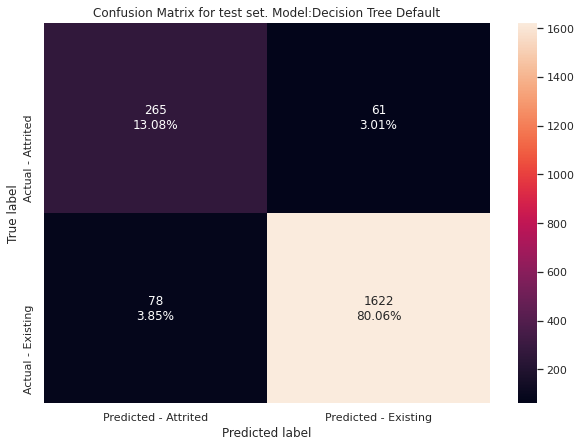

In [45]:
# Decision tree with default parameters
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Decision Tree Default"
GetScores(dt_default,model_name=name)
ConfusionMatrix(dt_default, y_test,set1="test", model_name = name)

**Insights:**
- The model overfits training data (attains 100 acc, precision, recall and f1).

## Decision Tree Classifier tuned - GridSearcCV

In [46]:
pipeline_dt = Pipeline(steps=[
                        ('pca', PCA()),
                        ("model",DecisionTreeClassifier(random_state=42))
])

# model = DecisionTreeClassifier(random_state=42)

param_grid = {
                'pca__n_components': [6,12,16],
                'model__criterion':["gini","entropy"],
                'model__max_depth': [3,6,9,12],
                'model__min_samples_split': [2, 4, 6, 8],
                'model__max_features': [2,6,12,"auto"]
             } 

# print(pipeline_dt.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
grid_obj = GridSearchCV(pipeline_dt , param_grid = param_grid,scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj = grid_obj.fit( X_val, y_val)

time_taken_dtgs = time.time()-start_time
print("It took {} seconds to execute".format(time_taken_dtgs))

# Set the dt_tuned to the best combination of parameters
dt_tuned = grid_obj.best_estimator_

#Print best parameters
print(grid_obj.best_params_)

# Fit the best algorithm to the train data.
dt_tuned.fit(X_train, y_train)

It took 7.634959936141968 seconds to execute
{'model__criterion': 'entropy', 'model__max_depth': 12, 'model__max_features': 6, 'model__min_samples_split': 4, 'pca__n_components': 16}


Pipeline(steps=[('pca', PCA(n_components=16)),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=12,
                                        max_features=6, min_samples_split=4,
                                        random_state=42))])

{
   "model_name": "Decision Tree Tuned GridSearchCV",
   "train_acc": 0.9730085582620145,
   "val_acc": 0.9037037037037037,
   "test_acc": 0.8938795656465943,
   "train_recall": 0.8954918032786885,
   "val_recall": 0.676923076923077,
   "test_recall": 0.6687116564417178,
   "train_precision": 0.9337606837606838,
   "val_precision": 0.7096774193548387,
   "test_precision": 0.6707692307692308,
   "train_f1": 0.9142259414225942,
   "val_f1": 0.6929133858267716,
   "test_f1": 0.6697388632872503,
   "execution_time": 7.634959936141968
}


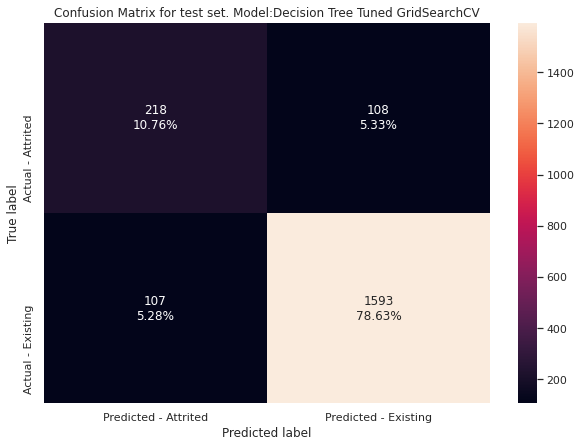

In [47]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Decision Tree Tuned GridSearchCV"
GetScores(dt_tuned,model_name=name, time_taken=time_taken_dtgs)
ConfusionMatrix(dt_tuned, y_test,set1="test", model_name = name)

## Decision Tree Classifier - RandomSearcCV

In [48]:
pipeline_dt2 = Pipeline(steps=[
                        ('pca', PCA()),
                        ("model",DecisionTreeClassifier(random_state=42))
])

# model = DecisionTreeClassifier(random_state=42)

param_grid2 = {
                'pca__n_components': sp_randint(6,16),
                'model__criterion':["gini","entropy"],
                'model__max_depth': sp_randint(3,12),
                'model__min_samples_split': sp_randint(2,8),
                'model__max_features': [2,6,12,"auto"]
             } 

# print(pipeline_dt2.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
rscv = RandomizedSearchCV(pipeline_dt2 , param_distributions = param_grid2,\
                          scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
rscv = rscv.fit( X_val, y_val) 

time_taken_dtrs = time.time()-start_time
print("It took {} seconds to execute".format(time_taken_dtrs))

# Set the dt_tuned to the best combination of parameters
dt_tuned2 = rscv.best_estimator_

#Print best parameters
print(rscv.best_params_)

# Fit the best algorithm to the train data.
dt_tuned2.fit(X_train, y_train)


It took 0.36071109771728516 seconds to execute
{'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 12, 'model__min_samples_split': 3, 'pca__n_components': 14}


Pipeline(steps=[('pca', PCA(n_components=14)),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        max_features=12, min_samples_split=3,
                                        random_state=42))])

{
   "model_name": "Decision Tree Tuned RandomSearchCV",
   "train_acc": 0.9537524687294272,
   "val_acc": 0.9101234567901234,
   "test_acc": 0.9215202369200395,
   "train_recall": 0.8483606557377049,
   "val_recall": 0.7323076923076923,
   "test_recall": 0.7668711656441718,
   "train_precision": 0.8616024973985432,
   "val_precision": 0.7147147147147147,
   "test_precision": 0.7507507507507507,
   "train_f1": 0.8549303045947341,
   "val_f1": 0.723404255319149,
   "test_f1": 0.7587253414264037,
   "execution_time": 0.36071109771728516
}


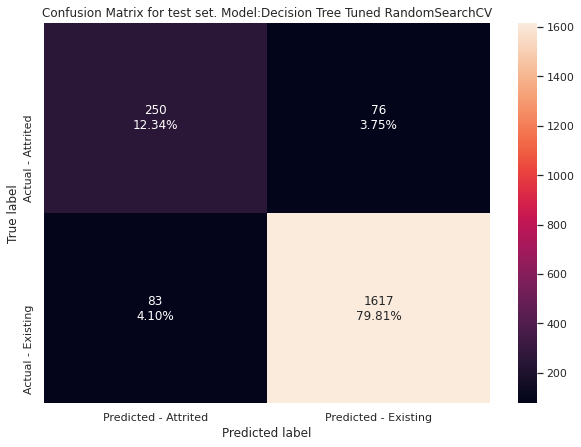

In [49]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Decision Tree Tuned RandomSearchCV"
GetScores(dt_tuned2,model_name=name, time_taken=time_taken_dtrs)
ConfusionMatrix(dt_tuned2, y_test,set1="test", model_name = name)

**Insights:**
  - Hyperparameter tuning Decison Tree classifier using validation data solved overfitting problem but model perfomance dropped slightly. The results are however still very good.
  - On execution time the GridSearchCV and RandomizedSearchCV performed as follows. We set n_jobs = c_count where c_count=cpu_count-1 so that we use the 7 CPU cores available to execute the searches. The latter executed so much faster than the former but it is still important to note the differences in the number of combinations in each search type. Other comparisons will be done at the end of the notebook.

In [50]:
print("It took {} seconds for GridSearchCV".format(time_taken_dtgs))
print("It took {} seconds for RandomizedSearchCV".format(time_taken_dtrs))

It took 7.634959936141968 seconds for GridSearchCV
It took 0.36071109771728516 seconds for RandomizedSearchCV


## Random Forest - default parameters

{
   "model_name": "Random Forest Default",
   "train_acc": 1.0,
   "val_acc": 0.945679012345679,
   "test_acc": 0.956071076011846,
   "train_recall": 1.0,
   "val_recall": 0.7353846153846154,
   "test_recall": 0.7822085889570553,
   "train_precision": 1.0,
   "val_precision": 0.908745247148289,
   "test_precision": 0.9340659340659341,
   "train_f1": 1.0,
   "val_f1": 0.8129251700680272,
   "test_f1": 0.8514190317195326,
   "execution_time": null
}


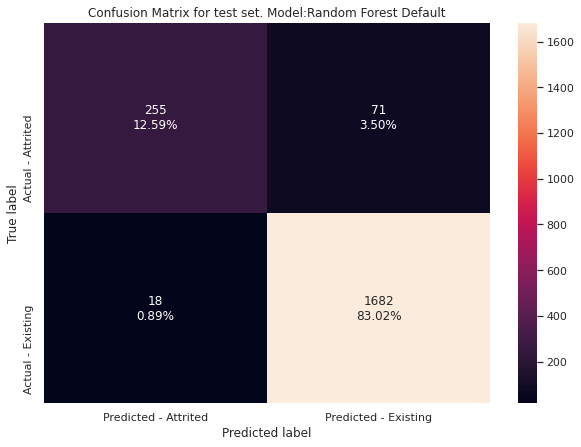

In [51]:
# Random forest with default parameters
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)

# Model performance
name = "Random Forest Default"
GetScores(rf_default, model_name=name)
ConfusionMatrix(rf_default,y_test, set1="test", model_name=name)

## Random Forest tuned - GridSearchCV

In [52]:
pipeline_rf_gs = make_pipeline(
                        (PCA()),
                        (RandomForestClassifier(random_state=42))
)

# Grid of parameters to choose from
parameters = {  "pca__n_components": [5,10,15,20],
                "randomforestclassifier__n_estimators": [50,100,200,250],
                "randomforestclassifier__min_samples_leaf": list(np.arange(4, 11,3)),
                "randomforestclassifier__max_features":  [0.4, 0.7, 0.9], #list(np.arange(0.2, 0.7, 0.1)),
                "randomforestclassifier__max_samples":  [0.4, 0.7, 0.9], #list(np.arange(0.3, 0.7, 0.1)),
                "randomforestclassifier__max_depth": [6,9,12]
            }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
start_time = time.time()

grid_obj_rf1 = GridSearchCV(pipeline_rf_gs, parameters, scoring=acc_scorer,cv=5, n_jobs=c_count)
grid_obj_rf1 = grid_obj_rf1.fit(X_val, y_val)

time_taken2 = time.time()-start_time

# print(pipeline_rf_gs.get_params().keys())

# Set the clf to the best combination of parameters
rf_estimator_tuned1 = grid_obj_rf1.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_tuned1.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=20)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, max_features=0.9,
                                        max_samples=0.9, min_samples_leaf=4,
                                        n_estimators=200, random_state=42))])

{
   "model_name": "Random Forest Tuned GridSearchCV",
   "train_acc": 0.9822251481237656,
   "val_acc": 0.9348148148148148,
   "test_acc": 0.9461994076999013,
   "train_recall": 0.9077868852459017,
   "val_recall": 0.7384615384615385,
   "test_recall": 0.7883435582822086,
   "train_precision": 0.9800884955752213,
   "val_precision": 0.8362369337979094,
   "test_precision": 0.8653198653198653,
   "train_f1": 0.9425531914893618,
   "val_f1": 0.7843137254901961,
   "test_f1": 0.8250401284109149,
   "execution_time": 1200.8105223178864
}


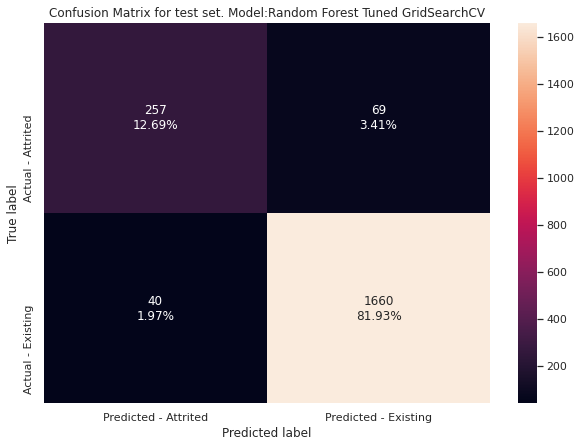

In [53]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Random Forest Tuned GridSearchCV"
GetScores(rf_estimator_tuned1,model_name=name, time_taken=time_taken2)
ConfusionMatrix(rf_estimator_tuned1, y_test,set1="test", model_name = name)

## Random Forest tuned - RandomSearchCV

In [54]:
pipeline_dt2 = make_pipeline(
                        (PCA()),
                        (RandomForestClassifier(random_state=42))
)

# model = DecisionTreeClassifier(random_state=42)
parameters2 = {  
                "pca__n_components": sp_randint(5,20),
                "randomforestclassifier__n_estimators": sp_randint(50,250),
                "randomforestclassifier__min_samples_leaf": sp_randint(5,12),
                "randomforestclassifier__max_features":  uniform(0.4,0.9), #list(np.arange(0.2, 0.7, 0.1)),
                "randomforestclassifier__max_samples":  uniform(0.4,0.9), #list(np.arange(0.3, 0.7, 0.1)),
                "randomforestclassifier__max_depth": sp_randint(3,12)
            }


# print(pipeline_dt2.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
grid_obj_rf2 = RandomizedSearchCV(pipeline_dt2 , param_distributions = parameters2,\
                          scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj_rf2 = grid_obj_rf2.fit( X_val, y_val) 

time_taken2 = time.time()-start_time
print("It took {} seconds to execute".format(time_taken2))

# Set the dt_tuned to the best combination of parameters
rf_estimator_tuned2 = grid_obj_rf2.best_estimator_

#Print best parameters
print(grid_obj_rf2.best_params_)

# Fit the best algorithm to the train data.
rf_estimator_tuned2.fit(X_train, y_train)


It took 4.505133867263794 seconds to execute
{'pca__n_components': 6, 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 0.7114309992402676, 'randomforestclassifier__max_samples': 0.799872206188945, 'randomforestclassifier__min_samples_leaf': 7, 'randomforestclassifier__n_estimators': 89}


Pipeline(steps=[('pca', PCA(n_components=6)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=9,
                                        max_features=0.7114309992402676,
                                        max_samples=0.799872206188945,
                                        min_samples_leaf=7, n_estimators=89,
                                        random_state=42))])

{
   "model_name": "Random Forest Tuned RandomSearchCV",
   "train_acc": 0.9473337722185649,
   "val_acc": 0.914074074074074,
   "test_acc": 0.9254689042448174,
   "train_recall": 0.7766393442622951,
   "val_recall": 0.6646153846153846,
   "test_recall": 0.6993865030674846,
   "train_precision": 0.8813953488372093,
   "val_precision": 0.7686832740213523,
   "test_precision": 0.8113879003558719,
   "train_f1": 0.8257080610021786,
   "val_f1": 0.7128712871287128,
   "test_f1": 0.7512355848434926,
   "execution_time": 4.505133867263794
}


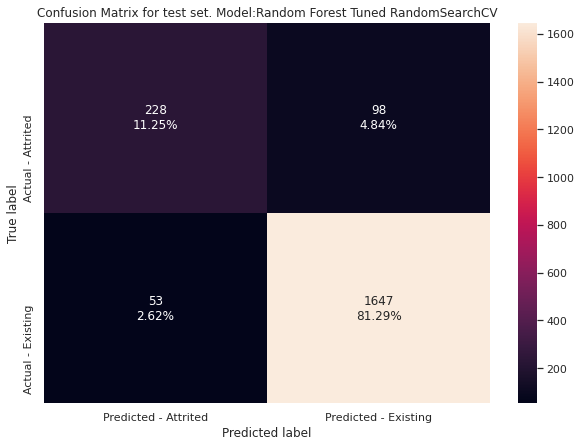

In [55]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Random Forest Tuned RandomSearchCV"
GetScores(rf_estimator_tuned2,model_name=name, time_taken=time_taken2)
ConfusionMatrix(rf_estimator_tuned2, y_test,set1="test", model_name = name)

## Bagging Classifier with default parameter

{
   "model_name": "Bagging Classifier Default",
   "train_acc": 0.9955562870309415,
   "val_acc": 0.9501234567901234,
   "test_acc": 0.9575518262586377,
   "train_recall": 0.9743852459016393,
   "val_recall": 0.8061538461538461,
   "test_recall": 0.8343558282208589,
   "train_precision": 0.9979013641133263,
   "val_precision": 0.8733333333333333,
   "test_precision": 0.8947368421052632,
   "train_f1": 0.9860031104199067,
   "val_f1": 0.8384,
   "test_f1": 0.8634920634920634,
   "execution_time": null
}


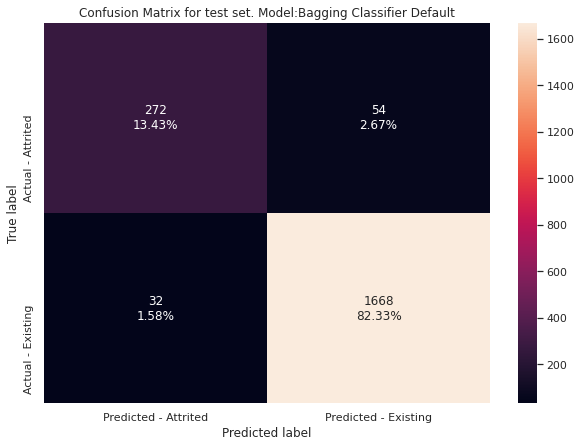

In [56]:
# Bagging classfier with default parameters.
# The base estimator is by default Decision Tree classifier
bagging_estimator = BaggingClassifier(random_state=42)
bagging_estimator.fit(X_train, y_train)

name = "Bagging Classifier Default"
GetScores(bagging_estimator,model_name=name)
ConfusionMatrix(bagging_estimator, y_test,set1="test", model_name = name)

## Bagging classifier tuned by GridSearchCV

In [57]:
pipeline_bagging1 = make_pipeline(
                        (PCA()),
                        (BaggingClassifier(random_state=42))
) # By default the base classifier used is Decision Tree. Another option 
# could be to use Logistic Model but we will keep it as defaulted

print(pipeline_bagging1.get_params().keys())

# model = DecisionTreeClassifier(random_state=42)
parameters1 = {  
                "baggingclassifier__n_estimators": np.arange(50,200,50),
                "baggingclassifier__max_features":  list(np.arange(0.2, 1.0, 0.2)),
                "baggingclassifier__max_samples":  list(np.arange(0.2, 1.0, 0.2)), 
            }


# print(pipeline_dt2.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
grid_obj_bagging1 = GridSearchCV(pipeline_bagging1 , parameters1,\
                          scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj_bagging1 = grid_obj_bagging1.fit( X_val, y_val) 

time_taken2 = time.time()-start_time
print("It took {} seconds to execute".format(time_taken2))

# Set the dt_tuned to the best combination of parameters
bagging_tuned1 = grid_obj_bagging1.best_estimator_

#Print best parameters
print(grid_obj_bagging1.best_params_)

# Fit the best algorithm to the train data.
bagging_tuned1.fit(X_train, y_train)


dict_keys(['memory', 'steps', 'verbose', 'pca', 'baggingclassifier', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'baggingclassifier__base_estimator', 'baggingclassifier__bootstrap', 'baggingclassifier__bootstrap_features', 'baggingclassifier__max_features', 'baggingclassifier__max_samples', 'baggingclassifier__n_estimators', 'baggingclassifier__n_jobs', 'baggingclassifier__oob_score', 'baggingclassifier__random_state', 'baggingclassifier__verbose', 'baggingclassifier__warm_start'])
It took 40.80746078491211 seconds to execute
{'baggingclassifier__max_features': 0.8, 'baggingclassifier__max_samples': 0.8, 'baggingclassifier__n_estimators': 150}


Pipeline(steps=[('pca', PCA()),
                ('baggingclassifier',
                 BaggingClassifier(max_features=0.8, max_samples=0.8,
                                   n_estimators=150, random_state=42))])

{
   "model_name": "Bagging Classifier Tuned GridSearchCV",
   "train_acc": 0.999670836076366,
   "val_acc": 0.9407407407407408,
   "test_acc": 0.947680157946693,
   "train_recall": 0.9979508196721312,
   "val_recall": 0.7507692307692307,
   "test_recall": 0.7699386503067485,
   "train_precision": 1.0,
   "val_precision": 0.8621908127208481,
   "test_precision": 0.8900709219858156,
   "train_f1": 0.9989743589743589,
   "val_f1": 0.8026315789473685,
   "test_f1": 0.8256578947368421,
   "execution_time": 40.80746078491211
}


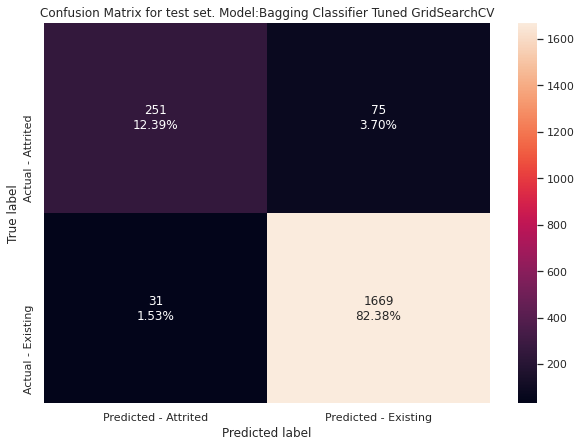

In [58]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Bagging Classifier Tuned GridSearchCV"
GetScores(bagging_tuned1,model_name=name, time_taken=time_taken2)
ConfusionMatrix(bagging_tuned1, y_test,set1="test", model_name = name)

## Bagging Classifier tuned by RandomSearchCV

In [59]:
pipeline_bagging2 = make_pipeline(
                        (PCA()),
                        (BaggingClassifier(random_state=42))
) # By default the base classifier used is Decision Tree. Another option 
# could be to use Logistic Model but we will keep it as defaulted

print(pipeline_bagging2.get_params().keys())


# model = DecisionTreeClassifier(random_state=42)
parameters2 = {  
                "baggingclassifier__n_estimators": sp_randint(50,200),
                "baggingclassifier__max_features": uniform(0.2, 1.0),
                "baggingclassifier__max_samples":  uniform(0.2, 1.0), 
            }


# print(pipeline_dt2.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
grid_obj_bagging2 = RandomizedSearchCV(pipeline_bagging2 , parameters2,\
                          scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj_bagging2 = grid_obj_bagging2.fit( X_val, y_val) 

time_taken2 = time.time()-start_time
print("It took {} seconds to execute".format(time_taken2))

# Set the dt_tuned to the best combination of parameters
bagging_tuned2 = grid_obj_bagging2.best_estimator_

#Print best parameters
print(grid_obj_bagging2.best_params_)

# Fit the best algorithm to the train data.
bagging_tuned2.fit(X_train, y_train)


dict_keys(['memory', 'steps', 'verbose', 'pca', 'baggingclassifier', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'baggingclassifier__base_estimator', 'baggingclassifier__bootstrap', 'baggingclassifier__bootstrap_features', 'baggingclassifier__max_features', 'baggingclassifier__max_samples', 'baggingclassifier__n_estimators', 'baggingclassifier__n_jobs', 'baggingclassifier__oob_score', 'baggingclassifier__random_state', 'baggingclassifier__verbose', 'baggingclassifier__warm_start'])
It took 14.360954999923706 seconds to execute
{'baggingclassifier__max_features': 0.9081637211128828, 'baggingclassifier__max_samples': 0.7759950868712546, 'baggingclassifier__n_estimators': 84}


Pipeline(steps=[('pca', PCA()),
                ('baggingclassifier',
                 BaggingClassifier(max_features=0.9081637211128828,
                                   max_samples=0.7759950868712546,
                                   n_estimators=84, random_state=42))])

{
   "model_name": "Bagging Classifier Tuned RandomSearchCV",
   "train_acc": 0.9986833443054641,
   "val_acc": 0.9437037037037037,
   "test_acc": 0.9521224086870681,
   "train_recall": 0.9918032786885246,
   "val_recall": 0.7692307692307693,
   "test_recall": 0.8006134969325154,
   "train_precision": 1.0,
   "val_precision": 0.8650519031141869,
   "test_precision": 0.8907849829351536,
   "train_f1": 0.9958847736625513,
   "val_f1": 0.8143322475570034,
   "test_f1": 0.8432956381260097,
   "execution_time": 14.360954999923706
}


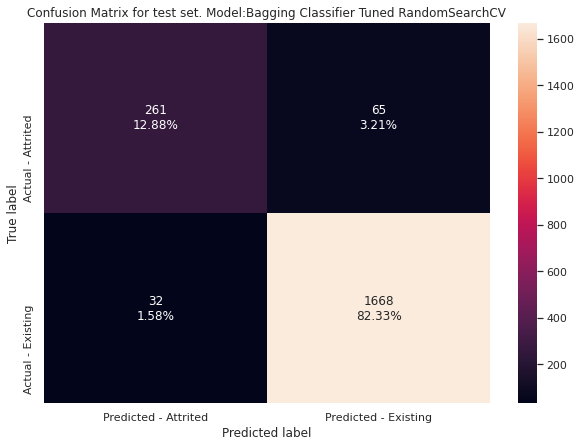

In [60]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Bagging Classifier Tuned RandomSearchCV"
GetScores(bagging_tuned2,model_name=name, time_taken=time_taken2)
ConfusionMatrix(bagging_tuned2, y_test,set1="test", model_name = name)

## AdaBoost Classifier - default parameters

{
   "model_name": "AdaBoost Classifier Default",
   "train_acc": 0.9629690585911784,
   "val_acc": 0.951604938271605,
   "test_acc": 0.9595261599210266,
   "train_recall": 0.8616803278688525,
   "val_recall": 0.8184615384615385,
   "test_recall": 0.8343558282208589,
   "train_precision": 0.9033297529538131,
   "val_precision": 0.8721311475409836,
   "test_precision": 0.9066666666666666,
   "train_f1": 0.8820136339800735,
   "val_f1": 0.8444444444444446,
   "test_f1": 0.8690095846645367,
   "execution_time": null
}


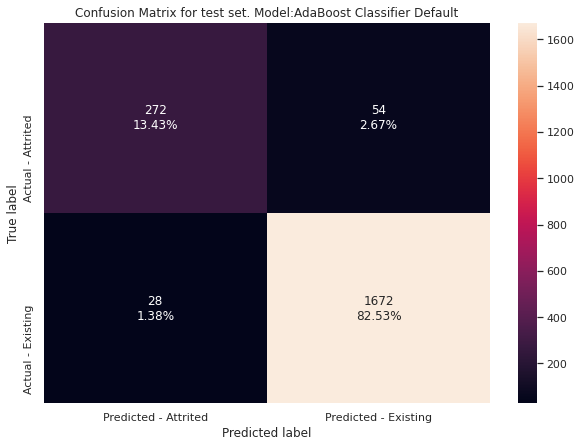

In [61]:
# Adaboost classifier with default parameters
ada_default = AdaBoostClassifier(random_state=1)
ada_default.fit(X_train,y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
name = "AdaBoost Classifier Default"
GetScores(ada_default, model_name=name)
ConfusionMatrix(ada_default, y_test,model_name=name, set1="test")

In [62]:
# Important features as per the ada_default classifier
importances = ada_default.feature_importances_
indices = np.argsort(importances)
feature_names = list(X_train.columns)
r = {
    "Column": feature_names,
    "Importance": importances
}
print(20*"#","TOP 3",20*"#")
df_important_ada = pd.DataFrame(r).sort_values(by="Importance", ascending=False)[:3]
df_important_ada

#################### TOP 3 ####################


Column  Importance
13  Total_Trans_Amt        0.34
14   Total_Trans_Ct        0.22
0      Customer_Age        0.06

**Comment:**

- The following 3 features are the most important according to AdaBoost Classifier : Total_Trans_Amt, Total_Trans_Ct and Total_Amt_Chng_Q4_Q1.

## Logisitic Model - with Cross-validation (and default parameters)

In [63]:
# logistic with 10-fold cross validation
logistic_cv = LogisticRegression(random_state=1)
kfold = KFold(n_splits = 10, shuffle=True)
results = cross_val_score(logistic_cv,df.drop(["Attrition_Flag"], axis=1), df["Attrition_Flag"], cv=kfold, scoring='roc_auc',n_jobs=c_count)
print(results)
print("Mean:",results.mean(),"Standard Deviation:", results.std())

[0.90340514 0.89362261 0.89436492 0.90205702 0.900254   0.90203167
 0.90036087 0.88427381 0.89441798 0.90543747]
Mean: 0.8980225478349109 Standard Deviation: 0.006012560807907433


## Logistic Model - with no cross-validation (and default parameters)

{
   "model_name": "Logistic Regression Default",
   "train_acc": 0.8852863726135616,
   "val_acc": 0.88,
   "test_acc": 0.8899308983218164,
   "train_recall": 0.48360655737704916,
   "val_recall": 0.4338461538461538,
   "test_recall": 0.5153374233128835,
   "train_precision": 0.7097744360902256,
   "val_precision": 0.705,
   "test_precision": 0.721030042918455,
   "train_f1": 0.5752589884216941,
   "val_f1": 0.537142857142857,
   "test_f1": 0.6010733452593918,
   "execution_time": null
}


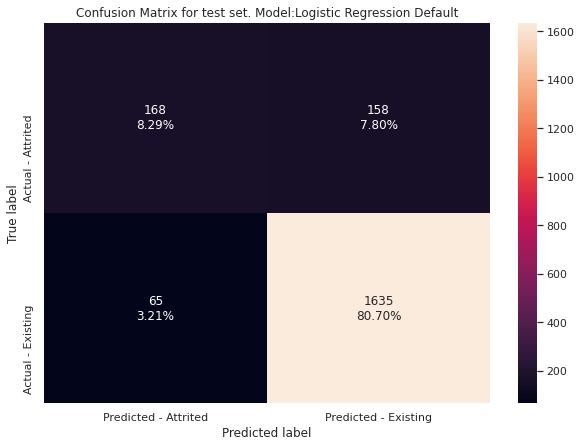

In [64]:
# Logistic regression model with default parameters
logistic_default = LogisticRegression(random_state=1)
logistic_default.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
name = "Logistic Regression Default"
GetScores(logistic_default, model_name=name)
ConfusionMatrix(logistic_default, y_test,set1="test", model_name=name)

## Logistic Model Tuned - GridSearchCV

In [65]:
pipeline_logistic = make_pipeline(
(PCA()), LogisticRegression(random_state=42)
)
print(pipeline_logistic.get_params().keys())

# model = DecisionTreeClassifier(random_state=42)
parameters1 = {  
                "pca__n_components": np.arange(4,25,6),
                "logisticregression__class_weight":  [{0: 0.8, 1: 0.2}],
                "logisticregression__tol":[1e-3,1e-4,1e-5],
                "logisticregression__solver": ["newton-cg", "lbfgs", "liblinear"]
            }


# print(pipeline_dt2.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
grid_obj_logistic1 = GridSearchCV(pipeline_logistic , parameters1,\
                          scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj_logistic1 = grid_obj_logistic1.fit( X_val, y_val) 

time_taken = time.time()-start_time
print("It took {} seconds to execute".format(time_taken))

# Set the dt_tuned to the best combination of parameters
logisitic_tuned1 = grid_obj_logistic1.best_estimator_

#Print best parameters
print(grid_obj_logistic1.best_params_)

# Fit the best algorithm to the train data.
logisitic_tuned1.fit(X_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'pca', 'logisticregression', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])
It took 3.6800553798675537 seconds to execute
{'logisticregression__class_weight': {0: 0.8, 1: 0.2}, 'logisticregression__solver': 'newton-cg', 'logisticregression__tol': 0.001, 'pca__n_components': 22}


Pipeline(steps=[('pca', PCA(n_components=22)),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 0.8, 1: 0.2},
                                    random_state=42, solver='newton-cg',
                                    tol=0.001))])

{
   "model_name": "Logistic Regression Tuned GridSearchCV",
   "train_acc": 0.8963133640552995,
   "val_acc": 0.8824691358024691,
   "test_acc": 0.8948667324777887,
   "train_recall": 0.3801229508196721,
   "val_recall": 0.3076923076923077,
   "test_recall": 0.3803680981595092,
   "train_precision": 0.9368686868686869,
   "val_precision": 0.8849557522123894,
   "test_precision": 0.9185185185185185,
   "train_f1": 0.5408163265306123,
   "val_f1": 0.4566210045662101,
   "test_f1": 0.5379609544468547,
   "execution_time": 3.6800553798675537
}


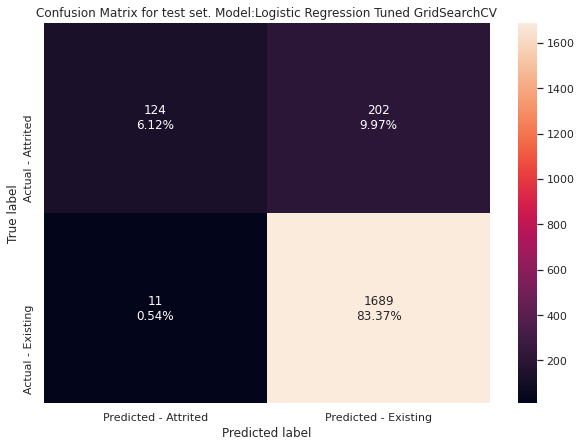

In [66]:
#Using above defined function to get accuracy, recall and precision on train and test set
name = "Logistic Regression Tuned GridSearchCV"
GetScores(logisitic_tuned1, model_name=name, time_taken=time_taken)
ConfusionMatrix(logisitic_tuned1, y_test,set1="test", model_name=name)

## Logistic Model Tuned - RandomizedSearchCV

In [67]:
pipeline_logistic = make_pipeline(
(PCA()), LogisticRegression(random_state=42)
)
print(pipeline_logistic.get_params().keys())

# model = DecisionTreeClassifier(random_state=42)
parameters2 = {  
                "pca__n_components": sp_randint(4,25),
                "logisticregression__class_weight":  [{0: 0.5, 1: 0.5}],
                "logisticregression__tol":[1e-3,1e-4,1e-5],
                "logisticregression__solver": ["newton-cg", "lbfgs", "liblinear"]
            }


# print(pipeline_dt2.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
start_time=time.time()
grid_obj_logistic2 = RandomizedSearchCV(pipeline_logistic , parameters2,\
                          scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj_logistic2 = grid_obj_logistic2.fit( X_val, y_val) 

time_taken = time.time()-start_time
print("It took {} seconds to execute".format(time_taken))

# Set the dt_tuned to the best combination of parameters
logisitic_tuned2 = grid_obj_logistic2.best_estimator_

#Print best parameters
print(grid_obj_logistic2.best_params_)

# Fit the best algorithm to the train data.
logisitic_tuned2.fit(X_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'pca', 'logisticregression', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])
It took 1.0036754608154297 seconds to execute
{'logisticregression__class_weight': {0: 0.5, 1: 0.5}, 'logisticregression__solver': 'liblinear', 'logisticregression__tol': 1e-05, 'pca__n_components': 23}


Pipeline(steps=[('pca', PCA(n_components=23)),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 0.5, 1: 0.5},
                                    random_state=42, solver='liblinear',
                                    tol=1e-05))])

{
   "model_name": "Logistic Regression Tuned RandomizedSearchCV",
   "train_acc": 0.9114549045424621,
   "val_acc": 0.905679012345679,
   "test_acc": 0.9131293188548865,
   "train_recall": 0.6301229508196722,
   "val_recall": 0.5846153846153846,
   "test_recall": 0.6196319018404908,
   "train_precision": 0.7765151515151515,
   "val_precision": 0.7723577235772358,
   "test_precision": 0.7952755905511811,
   "train_f1": 0.6957013574660633,
   "val_f1": 0.6654991243432575,
   "test_f1": 0.6965517241379311,
   "execution_time": 1.0036754608154297
}


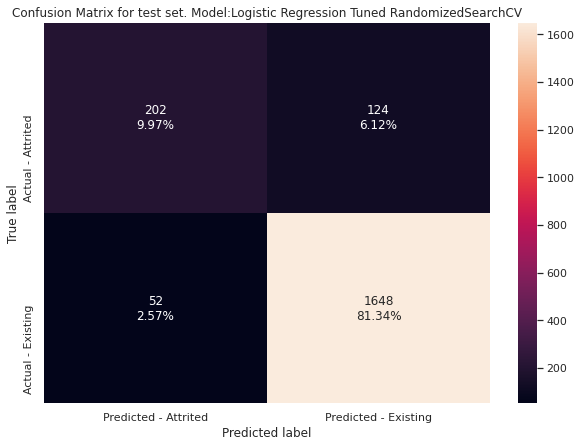

In [68]:
#Using above defined function to get accuracy, recall and precision on train and test set
name = "Logistic Regression Tuned RandomizedSearchCV"
GetScores(logisitic_tuned2, model_name=name, time_taken=time_taken)
ConfusionMatrix(logisitic_tuned2, y_test,set1="test", model_name=name)

## Logistic Regreesion - SMOTE applied

Before UpSampling, counts of label '1': 976
Before UpSampling, counts of label '0': 5100 

After UpSampling, counts of label '1': 5100
After UpSampling, counts of label '0': 5100 

After UpSampling, the shape of train_X: (10200, 23)
After UpSampling, the shape of train_y: (10200,) 

{
   "model_name": "Logistic Regression Oversampling SMOTE",
   "train_acc": 0.8191244239631337,
   "val_acc": 0.8138271604938272,
   "test_acc": 0.8307008884501481,
   "train_recall": 0.8002049180327869,
   "val_recall": 0.7815384615384615,
   "test_recall": 0.7975460122699386,
   "train_precision": 0.4635014836795252,
   "val_precision": 0.45357142857142857,
   "test_precision": 0.48417132216014896,
   "train_f1": 0.5869973694099963,
   "val_f1": 0.5740112994350283,
   "test_f1": 0.6025492468134415,
   "execution_time": 1.0036754608154297
}


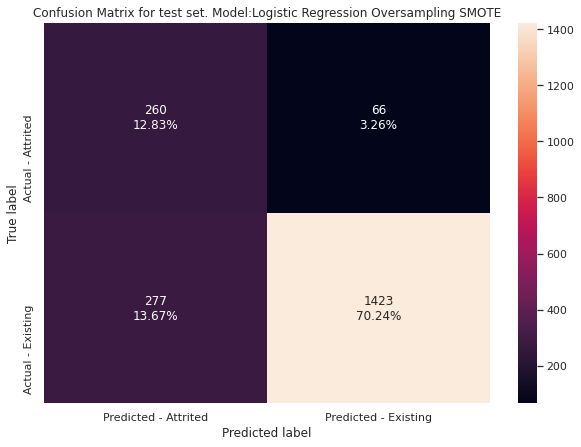

In [69]:
# Oversampling minority class (Attrited) using SMOTE algorithm

print("Before UpSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 1, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())


print("After UpSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))



print('After UpSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_res.shape))


# fit Logistic model on upsampled data 
logistic_model_upsampled = LogisticRegression(random_state=1)
logistic_model_upsampled.fit(X_train_res, y_train_res)


#Using above defined function to get accuracy, recall and precision on train and test set
name = "Logistic Regression Oversampling SMOTE"
GetScores(logistic_model_upsampled, model_name=name, time_taken=time_taken)
ConfusionMatrix(logistic_model_upsampled, y_test,set1="test", model_name=name)

**Insight:**

- Oversampling minority class using SMOTE improved the precision so much so that the model is so good in predicting attrited customers but the performance greatly declined in recall score.

In [70]:
# Downsampling

train_data = pd.DataFrame(y_train).join(X_train, how='outer')
print("Training rows", len(train_data))

attrited_indices = train_data[train_data['Attrition_Flag'] == 0].index  
attrited = len(train_data[train_data['Attrition_Flag'] == 0])   
print("Attried customers", len(attrited_indices))

existing_indices = train_data[train_data['Attrition_Flag'] == 1].index  
existing = len(train_data[train_data['Attrition_Flag'] == 1])   
print("Existing customers", len(existing_indices))

random_indices = np.random.choice( existing_indices, 971 , replace=False) 
all_sampled_indices = np.concatenate([attrited_indices,random_indices])
train_downsampled = df.loc[all_sampled_indices]
train_downsampled

print("On downsampling: ")
print("Attrited", len(train_downsampled[train_data['Attrition_Flag'] == 0]))
print("Existing", len(train_downsampled[train_data['Attrition_Flag'] == 1]))

X_ds = train_downsampled.drop(["Attrition_Flag"], axis=1)
y_ds = train_downsampled["Attrition_Flag"]


X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_ds, y_ds, test_size = 0.3, random_state=42)

# fit Logistic model on upsampled data 
logistic_model_downsampled = LogisticRegression(random_state=1)
logistic_model_downsampled.fit(X_train_ds, y_train_ds)

Training rows 6076
Attried customers 5100
Existing customers 976
On downsampling: 
Attrited 5100
Existing 971


LogisticRegression(random_state=1)

{
   "model_name": "Logistic Regression Downsampled",
   "train_acc": 0.89137590520079,
   "val_acc": 0.8814814814814815,
   "test_acc": 0.8919052319842053,
   "train_recall": 0.5184426229508197,
   "val_recall": 0.4676923076923077,
   "test_recall": 0.5245398773006135,
   "train_precision": 0.7270114942528736,
   "val_precision": 0.6940639269406392,
   "test_precision": 0.7276595744680852,
   "train_f1": 0.6052631578947368,
   "val_f1": 0.5588235294117647,
   "test_f1": 0.609625668449198,
   "execution_time": 1.0036754608154297
}


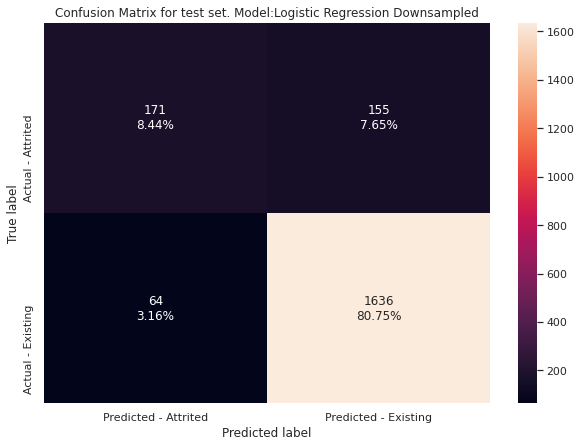

In [71]:
#Using above defined function to get accuracy, recall and precision on train and test set
name = "Logistic Regression Downsampled"
GetScores(logistic_model_downsampled, model_name=name, time_taken=time_taken)
ConfusionMatrix(logistic_model_downsampled, y_test,set1="test", model_name=name)


**Insight:**
- Again in downsampling, precision score improved but recall dropped. This means that the model find it easier to determine attrited customer than existing customer.

## AdaBoost Classifier Tuned - GridSearchCV

In [72]:

pipeline_ada = make_pipeline(
(PCA()),
    (AdaBoostClassifier(random_state=42))
)

# print(pipeline_ada.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Parameters grid
parameters_ada = {
    "pca__n_components": np.arange(4,21,5),
    #Let's try different max_depth for base_estimator
    "adaboostclassifier__base_estimator":[DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=12)],
    "adaboostclassifier__n_estimators": np.arange(30,151,20),
    "adaboostclassifier__learning_rate":np.arange(0.1,2,0.4)
}

# Run the grid search
start = time.time()
grid_obj_ada = GridSearchCV(pipeline_ada, parameters_ada, scoring=acc_scorer,cv=5, n_jobs=c_count)
grid_obj_ada = grid_obj_ada.fit(X_val, y_val)
time_taken = time.time()-start
print("The execution of time is {}".format(time_taken))

# The best parameters
# print(grid_obj_ada.get_params())
# Set the clf to the best combination of parameters
ada_tuned = grid_obj_ada.best_estimator_

# Fit the best algorithm to the data.
ada_tuned.fit(X_train, y_train)

The execution of time is 546.3218743801117


Pipeline(steps=[('pca', PCA(n_components=19)),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=1.7000000000000002,
                                    n_estimators=30, random_state=42))])

{
   "model_name": "AdaBoost Classifier Tuned GridSearchCV",
   "train_acc": 0.9837063857801185,
   "val_acc": 0.9308641975308642,
   "test_acc": 0.9343534057255676,
   "train_recall": 0.944672131147541,
   "val_recall": 0.7446153846153846,
   "test_recall": 0.7760736196319018,
   "train_precision": 0.953464322647363,
   "val_precision": 0.8093645484949833,
   "test_precision": 0.8083067092651757,
   "train_f1": 0.9490478641276378,
   "val_f1": 0.7756410256410257,
   "test_f1": 0.7918622848200312,
   "execution_time": 546.3218743801117
}


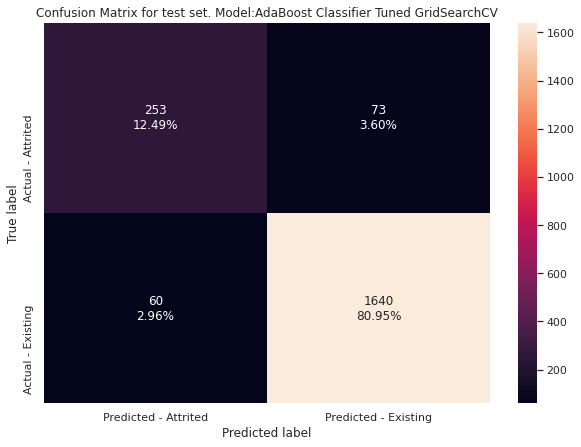

In [73]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "AdaBoost Classifier Tuned GridSearchCV"
GetScores(ada_tuned,model_name=name, time_taken=time_taken)
ConfusionMatrix(ada_tuned, y_test,set1="test", model_name = name)

## AdaBoost Classifier Tuned - RandomSearchCV

In [74]:
pipeline_ada2 = make_pipeline(
(PCA()),
    (AdaBoostClassifier(random_state=42))
)

# print(pipeline_ada.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Parameters grid
parameters_ada2 = {
    "pca__n_components": sp_randint(4,21),
    #Let's try different max_depth for base_estimator
    "adaboostclassifier__base_estimator":[DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=12)],
    "adaboostclassifier__n_estimators": sp_randint(30,151),
    "adaboostclassifier__learning_rate":uniform(0.1,2)
}

# Run the grid search
start = time.time()
grid_obj_ada2 = RandomizedSearchCV(pipeline_ada2, parameters_ada2, scoring=acc_scorer,cv=5, n_jobs=c_count)
grid_obj_ada2 = grid_obj_ada2.fit(X_val, y_val)
time_taken = time.time()-start
print("The execution of time is {}".format(time_taken))

# The best parameters
# print(grid_obj_ada2.get_params())
# Set the clf to the best combination of parameters
ada_tuned2 = grid_obj_ada2.best_estimator_

# Fit the best algorithm to the data.
ada_tuned2.fit(X_train, y_train)

The execution of time is 13.130846500396729


Pipeline(steps=[('pca', PCA(n_components=11)),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=1.4691881766598434,
                                    n_estimators=80, random_state=42))])

{
   "model_name": "AdaBoost Classifier Tuned RandomSearchCV",
   "train_acc": 0.999835418038183,
   "val_acc": 0.908641975308642,
   "test_acc": 0.922507403751234,
   "train_recall": 0.9989754098360656,
   "val_recall": 0.6707692307692308,
   "test_recall": 0.7638036809815951,
   "train_precision": 1.0,
   "val_precision": 0.7364864864864865,
   "test_precision": 0.756838905775076,
   "train_f1": 0.9994874423372629,
   "val_f1": 0.7020933977455718,
   "test_f1": 0.7603053435114503,
   "execution_time": 13.130846500396729
}


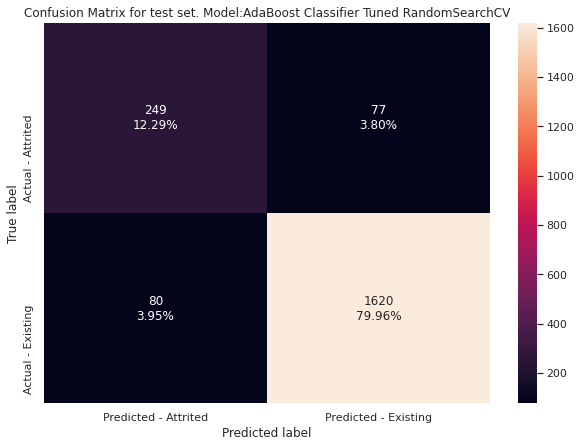

In [75]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "AdaBoost Classifier Tuned RandomSearchCV"
GetScores(ada_tuned2,model_name=name, time_taken=time_taken)
ConfusionMatrix(ada_tuned2, y_test,set1="test", model_name = name)

## Gradient Boosting Tuned - default parameter

{
   "model_name": "Gradient Boost Classifier",
   "train_acc": 0.9789335088874259,
   "val_acc": 0.957037037037037,
   "test_acc": 0.9679170779861797,
   "train_recall": 0.9057377049180327,
   "val_recall": 0.8123076923076923,
   "test_recall": 0.8404907975460123,
   "train_precision": 0.9608695652173913,
   "val_precision": 0.9103448275862069,
   "test_precision": 0.9547038327526133,
   "train_f1": 0.9324894514767932,
   "val_f1": 0.8585365853658536,
   "test_f1": 0.8939641109298532,
   "execution_time": null
}


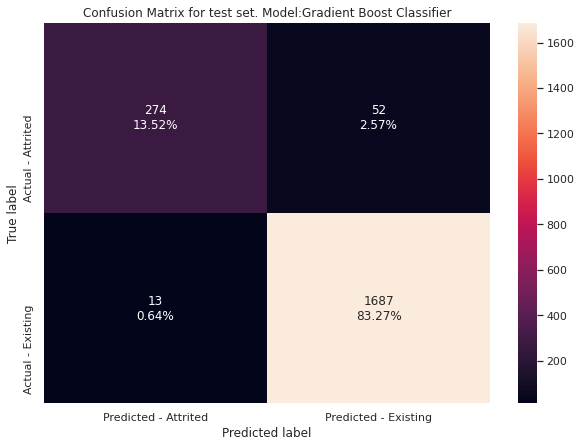

In [76]:
# Gradient Boosting Model
gbm_default = GradientBoostingClassifier(random_state=1)
gbm_default.fit(X_train,y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
name = "Gradient Boost Classifier"
GetScores(gbm_default, model_name=name)
ConfusionMatrix(gbm_default, y_test,model_name=name, set1="test")

In [77]:
importances = gbm_default.feature_importances_
indices = np.argsort(importances)
feature_names = list(X_train.columns)

r = {
    "Column": feature_names,
    "Importance": importances
}
print(20*"#","TOP 3",20*"#")
pd.DataFrame(r).sort_values(by="Importance", ascending=False)[:3]

#################### TOP 3 ####################


Column  Importance
14       Total_Trans_Ct    0.332521
13      Total_Trans_Amt    0.198179
10  Total_Revolving_Bal    0.170388

## Gradient Boosting Model - GridSearchCV

In [78]:
# Define the pipeline with two processes: PCA and the classifier
pipeline_gbm = make_pipeline(
        (PCA()),
        (GradientBoostingClassifier(random_state=1))
)

print(pipeline_gbm.get_params().keys())

# Grid of parameters to choose from
parameter_gbm = {
    "gradientboostingclassifier__n_estimators": np.arange(50,251,100),
    "gradientboostingclassifier__max_depth": np.arange(1,15,5),
    "gradientboostingclassifier__max_features": np.arange(0.4,1,0.2)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
start = time.time()

grid_obj_gbm = GridSearchCV(pipeline_gbm, parameter_gbm, scoring=acc_scorer,cv=5, n_jobs=c_count)
grid_obj_gbm = grid_obj_gbm.fit(X_val, y_val)

time_taken = time.time()-start
print("The execution of time is {}".format(time_taken))

# Set the clf to the best combination of parameters
gbm_tuned = grid_obj_gbm.best_estimator_

# Fit the best algorithm to the data.
gbm_tuned.fit(X_train, y_train)


dict_keys(['memory', 'steps', 'verbose', 'pca', 'gradientboostingclassifier', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_impurity_split', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassifier__random_state', 'gradientboostingclassifier__subsample', 'gradientboostingclassifier__tol', 

Pipeline(steps=[('pca', PCA()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=11,
                                            max_features=0.8000000000000002,
                                            n_estimators=150,
                                            random_state=1))])

{
   "model_name": "Gradient Boost Classifier Tuned GridSearchCV",
   "train_acc": 1.0,
   "val_acc": 0.9501234567901234,
   "test_acc": 0.9506416584402764,
   "train_recall": 1.0,
   "val_recall": 0.7907692307692308,
   "test_recall": 0.8098159509202454,
   "train_precision": 1.0,
   "val_precision": 0.8862068965517241,
   "test_precision": 0.8741721854304636,
   "train_f1": 1.0,
   "val_f1": 0.8357723577235773,
   "test_f1": 0.8407643312101911,
   "execution_time": 74.91167831420898
}


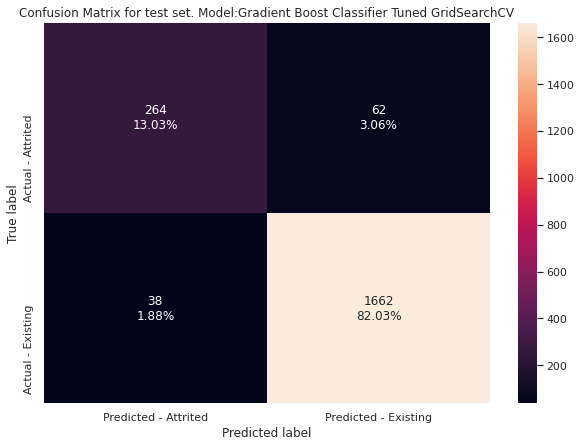

In [79]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Gradient Boost Classifier Tuned GridSearchCV"
GetScores(gbm_tuned,model_name=name, time_taken=time_taken)
ConfusionMatrix(gbm_tuned, y_test,set1="test", model_name = name)

## Gradient Boosting Model - RandomSearchCV

In [80]:
# Define the pipeline with two processes: PCA and the classifier
pipeline_gbm1 = make_pipeline(
        (PCA()),
        (GradientBoostingClassifier(random_state=1))
)

print(pipeline_gbm1.get_params().keys())

# Grid of parameters to choose from
parameter_gbm1 = {
    "gradientboostingclassifier__n_estimators": sp_randint(50,251),
    "gradientboostingclassifier__max_depth": sp_randint(1,15),
    "gradientboostingclassifier__max_features": uniform(0.4,1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
start = time.time()
grid_obj_gbm1 = RandomizedSearchCV(pipeline_gbm1, parameter_gbm1, scoring=acc_scorer,cv=5, n_jobs=c_count)
grid_obj_gbm1 = grid_obj_gbm1.fit(X_val, y_val)
time_taken = time.time()-start
print("The execution of time is {}".format(time_taken))

# Set the clf to the best combination of parameters
gbm_tuned1 = grid_obj_gbm1.best_estimator_

# Fit the best algorithm to the data.
gbm_tuned1.fit(X_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'pca', 'gradientboostingclassifier', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_impurity_split', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassifier__random_state', 'gradientboostingclassifier__subsample', 'gradientboostingclassifier__tol', 

Pipeline(steps=[('pca', PCA()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=7,
                                            max_features=0.5849227424919804,
                                            n_estimators=163,
                                            random_state=1))])

{
   "model_name": "Gradient Boost Classifier Tuned RandomSearchCV",
   "train_acc": 1.0,
   "val_acc": 0.9575308641975309,
   "test_acc": 0.956071076011846,
   "train_recall": 1.0,
   "val_recall": 0.8153846153846154,
   "test_recall": 0.8190184049079755,
   "train_precision": 1.0,
   "val_precision": 0.9106529209621993,
   "test_precision": 0.898989898989899,
   "train_f1": 1.0,
   "val_f1": 0.8603896103896104,
   "test_f1": 0.8571428571428571,
   "execution_time": 17.795301914215088
}


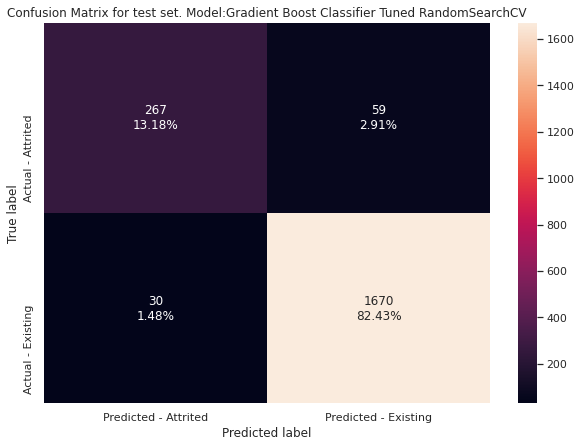

In [81]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "Gradient Boost Classifier Tuned RandomSearchCV"
GetScores(gbm_tuned1, model_name=name, time_taken=time_taken)
ConfusionMatrix(gbm_tuned1, y_test, set1="test", model_name = name)

## XGBoost Model - default parameters

{
   "model_name": "XGBoost Model Default",
   "train_acc": 1.0,
   "val_acc": 0.965925925925926,
   "test_acc": 0.9743336623889437,
   "train_recall": 1.0,
   "val_recall": 0.8492307692307692,
   "test_recall": 0.8957055214723927,
   "train_precision": 1.0,
   "val_precision": 0.9324324324324325,
   "test_precision": 0.9419354838709677,
   "train_f1": 1.0,
   "val_f1": 0.8888888888888888,
   "test_f1": 0.9182389937106917,
   "execution_time": null
}


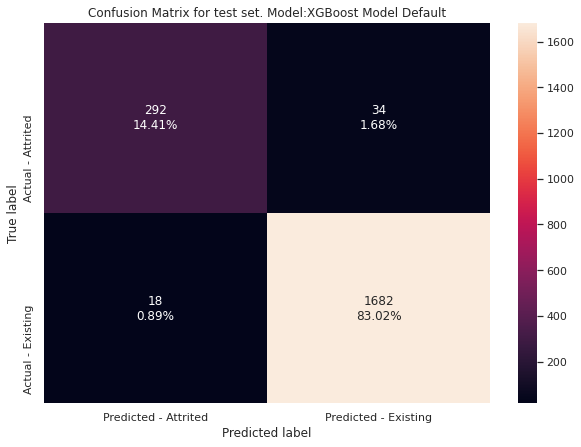

In [82]:
# Extreme Gradient Boosting Classifier alias XGBoost

xgb_default = XGBClassifier(random_state=1)
xgb_default.fit(X_train,y_train,eval_metric="logloss")

#Using above defined function to get accuracy, recall and precision on train and test set
name = "XGBoost Model Default"
GetScores(xgb_default, model_name=name)
ConfusionMatrix(xgb_default,y_test, model_name=name, set1="test")


## XGBoost Model Tuned- GridSearchCV

**Note:** For some reason the use of pipeline did not work in XGBoost models.

In [87]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1,use_label_encoder=False)

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": [50,100,150],
    "scale_pos_weight":[2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Start the time
start_time = time.time()

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_val, y_val, eval_metric="logloss")

# Evaluate time taken
time_taken = time.time()-start_time
print("Execution time: ",time_taken)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train, eval_metric="logloss")

Execution time:  841.8245184421539


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.7, gamma=3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

{
   "model_name": "XGBoost Classifier Tuned GridSearchCV",
   "train_acc": 0.9858459512837393,
   "val_acc": 0.9595061728395061,
   "test_acc": 0.9679170779861797,
   "train_recall": 0.9989754098360656,
   "val_recall": 0.9015384615384615,
   "test_recall": 0.950920245398773,
   "train_precision": 0.9198113207547169,
   "val_precision": 0.8542274052478134,
   "test_precision": 0.8635097493036211,
   "train_f1": 0.9577603143418468,
   "val_f1": 0.8772455089820359,
   "test_f1": 0.9051094890510949,
   "execution_time": 841.8245184421539
}


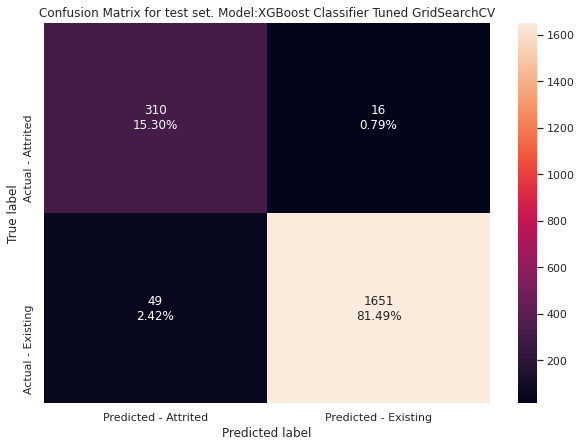

In [89]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "XGBoost Classifier Tuned GridSearchCV"
GetScores(xgb_tuned, model_name=name, time_taken=time_taken)
ConfusionMatrix(xgb_tuned, y_test, set1="test", model_name = name)

## XGBoost Model Tuned - RandomSearchCV

In [90]:
# Model object
pipeline_xgb1 = XGBClassifier(random_state=1, use_label_encoder=False)
               

# Grid of parameters
parameters_xgb1 = {
                    "n_estimators": sp_randint(10,100),
                    "subsample": [0.5,0.7,0.9,1],
                    "learning_rate":[0.01,0.1,0.2,0.05],
                    "gamma":sp_randint(0,3),
                    "colsample_bytree": [0.5,0.7,0.9,1],
                    "colsample_bylevel":[0.5,0.7,0.9,1]
                }

# Parameters are tuned to the best performance based on this metric
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Defind the parameters on the grid
# Start the time
start_time = time.time()

# Grid Seach
grid_obj_xgb1 = RandomizedSearchCV(pipeline_xgb1, parameters_xgb1,scoring=acc_scorer, cv=5)
grid_obj_xgb1 = grid_obj_xgb1.fit(X_val, y_val, eval_metric="logloss")

# Evaluate time taken
time_taken = time.time()-start_time
print("Execution time: ",time_taken)

# Set the clf to the best combination of parameters
xgb_tuned1 = grid_obj_xgb1.best_estimator_

# Fit algorithm on the best parameters
xgb_tuned1.fit(X_train, y_train, eval_metric="logloss")

Execution time:  3.4681594371795654


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.5, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=45, n_jobs=8, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

{
   "model_name": "XGBoost Classifier Tuned RandomSearchCV",
   "train_acc": 0.9835418038183015,
   "val_acc": 0.96,
   "test_acc": 0.9679170779861797,
   "train_recall": 0.9272540983606558,
   "val_recall": 0.8184615384615385,
   "test_recall": 0.843558282208589,
   "train_precision": 0.9689507494646681,
   "val_precision": 0.9236111111111112,
   "test_precision": 0.9515570934256056,
   "train_f1": 0.9476439790575917,
   "val_f1": 0.8678629690048939,
   "test_f1": 0.894308943089431,
   "execution_time": 3.4681594371795654
}


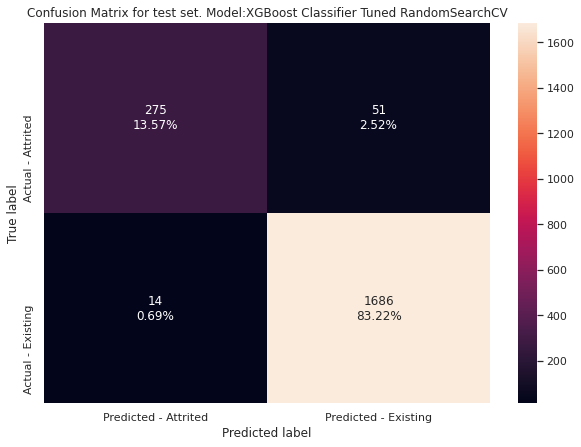

In [91]:
#Call get_score and ConfusionMatrix functions to evaluate the said model
name = "XGBoost Classifier Tuned RandomSearchCV"
GetScores(xgb_tuned1, model_name=name, time_taken=time_taken)
ConfusionMatrix(xgb_tuned1, y_test, set1="test", model_name = name)

In [93]:
pd.DataFrame(model_results).round(4)#.to_csv("resultsSUBMISSSION.csv", index=False)

model_name  train_acc  val_acc  \
0                            Decision Tree Default     1.0000   0.9353   
1                 Decision Tree Tuned GridSearchCV     0.9730   0.9037   
2               Decision Tree Tuned RandomSearchCV     0.9538   0.9101   
3                            Random Forest Default     1.0000   0.9457   
4                 Random Forest Tuned GridSearchCV     0.9822   0.9348   
5               Random Forest Tuned RandomSearchCV     0.9473   0.9141   
6                       Bagging Classifier Default     0.9956   0.9501   
7            Bagging Classifier Tuned GridSearchCV     0.9997   0.9407   
8          Bagging Classifier Tuned RandomSearchCV     0.9987   0.9437   
9                      AdaBoost Classifier Default     0.9630   0.9516   
10                     Logistic Regression Default     0.8853   0.8800   
11          Logistic Regression Tuned GridSearchCV     0.8963   0.8825   
12    Logistic Regression Tuned RandomizedSearchCV     0.9115   0.9057   
13          Logistic Regression Oversampling SMOTE     0.8191   0.8138   
14                 Logistic Regression Downsampled     0.8914   0.8815   
15          AdaBoost Classifier Tuned GridSearchCV     0.9837   0.9309   
16        AdaBoost Classifier Tuned RandomSearchCV     0.9998   0.9086   
17                       Gradient Boost Classifier     0.9789   0.9570   
18    Gradient Boost Classifier Tuned GridSearchCV     1.0000   0.9501   
19  Gradient Boost Classifier Tuned RandomSearchCV     1.0000   0.9575   
20                           XGBoost Model Default     1.0000   0.9659   
21           XGBoost Classifier Tuned GridSearchCV     0.9858   0.9595   
22         XGBoost Classifier Tuned RandomSearchCV     0.9835   0.9600   

    test_acc  train_recall  val_recall  test_recall  train_precision  \
0     0.9314        1.0000      0.7908       0.8129           1.0000   
1     0.8939        0.8955      0.6769       0.6687           0.9338   
2     0.9215        0.8484      0.7323       0.7669           0.8616   
3     0.9561        1.0000      0.7354       0.7822           1.0000   
4     0.9462        0.9078      0.7385       0.7883           0.9801   
5     0.9255        0.7766      0.6646       0.6994           0.8814   
6     0.9576        0.9744      0.8062       0.8344           0.9979   
7     0.9477        0.9980      0.7508       0.7699           1.0000   
8     0.9521        0.9918      0.7692       0.8006           1.0000   
9     0.9595        0.8617      0.8185       0.8344           0.9033   
10    0.8899        0.4836      0.4338       0.5153           0.7098   
11    0.8949        0.3801      0.3077       0.3804           0.9369   
12    0.9131        0.6301      0.5846       0.6196           0.7765   
13    0.8307        0.8002      0.7815       0.7975           0.4635   
14    0.8919        0.5184      0.4677       0.5245           0.7270   
15    0.9344        0.9447      0.7446       0.7761           0.9535   
16    0.9225        0.9990      0.6708       0.7638           1.0000   
17    0.9679        0.9057      0.8123       0.8405           0.9609   
18    0.9506        1.0000      0.7908       0.8098           1.0000   
19    0.9561        1.0000      0.8154       0.8190           1.0000   
20    0.9743        1.0000      0.8492       0.8957           1.0000   
21    0.9679        0.9990      0.9015       0.9509           0.9198   
22    0.9679        0.9273      0.8185       0.8436           0.9690   

    val_precision  test_precision  train_f1  val_f1  test_f1  execution_time  
0          0.8031          0.7726    1.0000  0.7969   0.7922             NaN  
1          0.7097          0.6708    0.9142  0.6929   0.6697          7.6350  
2          0.7147          0.7508    0.8549  0.7234   0.7587          0.3607  
3          0.9087          0.9341    1.0000  0.8129   0.8514             NaN  
4          0.8362          0.8653    0.9426  0.7843   0.8250       1200.8105  
5          0.7687          0.8114    0.8257  0.7129   0.7512

**Comments:**
- XGBoost fine-tuned with GridSearch with default parameters on test_recall performed best. In general, XGBoost model variants makes the best models.
- In terms of execution time, RandomizedSearchCV was faster than the GridSearchCV as show in the excution column in the table above. It is, however, noteworthy that the number of combinations are different for the two search algorithms. 
- Downsamplind and upsampling did not help to make the models better. In fact varying class weight was even a better way to deal with data imbalance.